# **Deep learning**
### Here is the final notebook- predicting using deep learning models
### I will provide here 2 predictions, 1 predicting absolute prices & predicting returns
***For each model I will us (1) own features (2) adding external data (3) Adding economic data**


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,RobustScaler
from sklearn.metrics import mean_squared_error,r2_score
import random

In [2]:
model_list = pd.DataFrame()

In [3]:
# Seed Python, NumPy, and TensorFlow RNGs
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
directory = 'raw_files'

# Import the data

In [5]:
import sys
import numpy.core.numeric as new_numeric

# Create a fake module under the old name
sys.modules['numpy._core.numeric'] = new_numeric

SPY = pd.read_pickle(r'raw_files\combined_cleaned_add_with_QQQ.pkl')
SPY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2055 non-null   datetime64[ns]
 1   SPY_Close            2055 non-null   float64       
 2   SPY_Volume           2055 non-null   int64         
 3   AAPL                 2055 non-null   float64       
 4   MSFT                 2055 non-null   float64       
 5   GOOG                 2055 non-null   float64       
 6   GLD                  2055 non-null   float64       
 7   SLV                  2055 non-null   float64       
 8   ^TNX                 2055 non-null   float64       
 9   DX-Y.NYB             2055 non-null   float64       
 10  JPY=X                2055 non-null   float64       
 11  EUR=X                2055 non-null   float64       
 12  USO                  2055 non-null   float64       
 13  UNG                  2055 non-nul

# Add support and resistance areas
Adding indicator for support and resistance areas

In [6]:
from scipy.signal import argrelextrema
spy_zones = SPY.copy()

# Use N = window size to define "local"
N = 10

# Find local maxima (resistance) and minima (support)
spy_zones['local_max'] = spy_zones['SPY_Close'].iloc[argrelextrema(spy_zones['SPY_Close'].values, np.greater_equal, order=N)[0]]
spy_zones['local_min'] = spy_zones['SPY_Close'].iloc[argrelextrema(spy_zones['SPY_Close'].values, np.less_equal, order=N)[0]]


# Define zone precision (e.g., $100 buckets)
zone_precision = 100
support_levels = spy_zones['local_min'].dropna().round(-int(np.log10(zone_precision)))
resistance_levels = spy_zones['local_max'].dropna().round(-int(np.log10(zone_precision)))

support_zones = support_levels.value_counts().loc[lambda x: x > 1].index.tolist()
resistance_zones = resistance_levels.value_counts().loc[lambda x: x > 1].index.tolist()

In [7]:
# define your margins
margin_sup = 50.0    # dollars above support to trigger 1
margin_res = 50.0    # dollars below resistance to trigger -1

def support_signal(price):
    # compute (distance, support) for only those supports below or equal to price
    diffs = [(price - s, s) for s in support_zones if s <= price]
    if not diffs:
        return 0
    # pick the smallest positive distance
    nearest_diff, nearest_sup = min(diffs, key=lambda x: x[0])
    return 1 if nearest_diff <= margin_sup else 0

def resistance_signal(price):
    # compute (distance, resistance) for only those resistances above or equal to price
    diffs = [(r - price, r) for r in resistance_zones if r >= price]
    if not diffs:
        return 0
    nearest_diff, nearest_res = min(diffs, key=lambda x: x[0])
    return -1 if nearest_diff <= margin_res else 0

# apply to your DataFrame
spy_zones['SUPPORT_Signal']    = spy_zones['SPY_Close'].apply(support_signal)
spy_zones['RESISTANCE_Signal'] = spy_zones['SPY_Close'].apply(resistance_signal)

# quick check
print(spy_zones[['SPY_Close','SUPPORT_Signal','RESISTANCE_Signal']].tail(60))


        SPY_Close  SUPPORT_Signal  RESISTANCE_Signal
1995  6086.370117               0                 -1
1996  6118.709961               0                  0
1997  6101.240234               0                  0
1998  6012.279785               0                  0
1999  6067.700195               0                 -1
2000  6039.310059               0                  0
2001  6071.169922               0                 -1
2002  6040.529785               0                  0
2003  5994.569824               0                  0
2004  6037.879883               0                  0
2005  6061.479980               0                 -1
2006  6083.569824               0                 -1
2007  6025.990234               0                  0
2008  6066.439941               0                 -1
2009  6068.500000               0                 -1
2010  6051.970215               0                 -1
2011  6115.069824               0                  0
2012  6114.629883               0             

In [8]:
spy_zones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2055 non-null   datetime64[ns]
 1   SPY_Close            2055 non-null   float64       
 2   SPY_Volume           2055 non-null   int64         
 3   AAPL                 2055 non-null   float64       
 4   MSFT                 2055 non-null   float64       
 5   GOOG                 2055 non-null   float64       
 6   GLD                  2055 non-null   float64       
 7   SLV                  2055 non-null   float64       
 8   ^TNX                 2055 non-null   float64       
 9   DX-Y.NYB             2055 non-null   float64       
 10  JPY=X                2055 non-null   float64       
 11  EUR=X                2055 non-null   float64       
 12  USO                  2055 non-null   float64       
 13  UNG                  2055 non-nul

Display a list of all the columns I have 

In [9]:
print(SPY.columns.to_list())

['ds', 'SPY_Close', 'SPY_Volume', 'AAPL', 'MSFT', 'GOOG', 'GLD', 'SLV', '^TNX', 'DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO', 'UNG', 'BTC-USD', 'CPER', '^VIX', '^GDAXI', '^FTSE', '^RUT', '^N225', 'IEI', 'CNYUSD=X', '2Y_Yield', 'yield_curve', 'market_closed_count', 'yield_curve_term', 'high-low', 'before_high-low', 'SPY_RSI', 'RSI_rank', 'RSI_rank_2', 'EMA_20', 'EMA_50', 'EMA_200', 'EMA_20_50', 'EMA_50_200', 'EMA_50_diff', 'EMA_200_diff', 'SPY_std', 'SPY_mean', 'SPY_30', 'QQQ_Close', 'QQQ_Volume', 'qqq_std', 'qqq_mean']


## Add RSI , MACD & averages
### Creat a function to establish final DF for medeling

In [10]:
def calculate_rsi(prices, period=14):
    prices = pd.to_numeric(prices, errors='coerce')
    delta  = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

  # MACD Calculation
def calculate_macd(prices, fast=12, slow=26):
    prices = pd.Series(prices).astype(float).dropna()
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    return exp1 - exp2

# number of consecative up/down days     
def calculate_consecutive_streak(close_series: pd.Series) -> pd.Series:
    """
    Calculate the consecutive up/down streaks for a close price series.
    - If today's close > yesterday's, streak = previous_streak + 1 (or 1 if previous_streak <= 0)
    - If today's close < yesterday's, streak = previous_streak - 1 (or -1 if previous_streak >= 0)
    - If equal, streak = 0
    """
    streak = [0] * len(close_series)
    for i in range(1, len(close_series)):
        if close_series.iat[i] > close_series.iat[i - 1]:
            streak[i] = streak[i - 1] + 1 if streak[i - 1] > 0 else 1
        elif close_series.iat[i] < close_series.iat[i - 1]:
            streak[i] = streak[i - 1] - 1 if streak[i - 1] < 0 else -1
        else:
            streak[i] = 0
    return pd.Series(streak, index=close_series.index, name='consecutive_streak')

# Add some internal features 
#
def model_own_features(
    data: pd.DataFrame,
    column: str,
    keep_columns = None
) -> pd.DataFrame:
    """
    Add RSI, MACD, rolling means, std, and consecutive streak for `column`.
    Optionally preserve only keep_columns + new features.
    """
    df = data.copy()
    # Ensure numeric
    df[column] = pd.to_numeric(df[column], errors='coerce')
    
    # 1) RSI
    df['RSI_14'] = calculate_rsi(df[column], period=14)
    
    # 2) MACD
    #macd_df = calculate_macd(df[column])
    #df = df.join(macd_df)
    df['MACD'] = calculate_macd(df[column])
    # 3) Rolling stats
    df['20d_mean'] = df[column].rolling(20).mean()
    df['5d_mean']  = df[column].rolling(5).mean()
    df['5d_std']   = df[column].rolling(5).std()
    
    # 4) Consecutive streak
    df['streak'] = calculate_consecutive_streak(df[column])
    
    # 5) Select output columns
    if keep_columns is not None:
        # always include the new features
        new_feats = ['RSI_14', 'MACD', '20d_mean', '5d_mean', '5d_std', 'streak']
        df = df[ keep_columns + new_feats ]

    df = df.dropna()

    return df


### Add feature to calculate consecative return 

In [11]:
# calculate the cosecative returns
def calculate_consecutive_return(close_series: pd.Series, streak_series: pd.Series) -> pd.Series:
    """
    Calculate the percentage change over the span of the consecutive streak.
    - If streak == 0: 0
    - Else: (close_today / close_n_days_ago - 1) * 100, where n = abs(streak)
    """
    returns = []
    prices = close_series.values
    streaks = streak_series.values.astype(int)
    for i, (price, streak) in enumerate(zip(prices, streaks)):
        n = abs(streak)
        if n > 0 and i - n >= 0:
            prev_price = prices[i - n]
            returns.append((price / prev_price - 1) * 100)
        else:
            returns.append(0.0)
    return pd.Series(returns, index=close_series.index, name='abs_consecutive_change')



### Add date features

In [12]:
def date_features(df):
    df['month'] = df['ds'].dt.month
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['day_of_week'] = df['day_of_week'] + 2
    return df

In [98]:
#initiating the df for modelling
result = model_own_features(
    data=SPY,
    column='SPY_Close',
    keep_columns=['SPY_Close','high-low','before_high-low','SPY_Volume','ds']
)

result['abs_consecutive_change'] = calculate_consecutive_return(result['SPY_Close'], result['streak'])
result = date_features(result) # to add date features
result = result.drop('ds',axis=1) # drop the date column
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2036 entries, 19 to 2054
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SPY_Close               2036 non-null   float64
 1   high-low                2036 non-null   float64
 2   before_high-low         2036 non-null   float64
 3   SPY_Volume              2036 non-null   int64  
 4   RSI_14                  2036 non-null   float64
 5   MACD                    2036 non-null   float64
 6   20d_mean                2036 non-null   float64
 7   5d_mean                 2036 non-null   float64
 8   5d_std                  2036 non-null   float64
 9   streak                  2036 non-null   int64  
 10  abs_consecutive_change  2036 non-null   float64
 11  month                   2036 non-null   int32  
 12  day_of_week             2036 non-null   int32  
dtypes: float64(9), int32(2), int64(2)
memory usage: 206.8 KB


In [99]:
# resetting the index
result = result.reset_index(drop=True)

result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SPY_Close               2036 non-null   float64
 1   high-low                2036 non-null   float64
 2   before_high-low         2036 non-null   float64
 3   SPY_Volume              2036 non-null   int64  
 4   RSI_14                  2036 non-null   float64
 5   MACD                    2036 non-null   float64
 6   20d_mean                2036 non-null   float64
 7   5d_mean                 2036 non-null   float64
 8   5d_std                  2036 non-null   float64
 9   streak                  2036 non-null   int64  
 10  abs_consecutive_change  2036 non-null   float64
 11  month                   2036 non-null   int32  
 12  day_of_week             2036 non-null   int32  
dtypes: float64(9), int32(2), int64(2)
memory usage: 191.0 KB


In [13]:

def evaluate_models_with_price_scaler(
    model_lstm,
    model_gru,
    X_test,
    y_test,           # still scaled
    scaler,           # MinMaxScaler fitted on the original price series
    dates=None        # optional: pd.DatetimeIndex or list of datetime labels
):
    # 1) Generate predictions in scaled space
    pred_lstm_scaled = model_lstm.predict(X_test)
    pred_gru_scaled  = model_gru.predict(X_test)

    # 2) Build a fresh scaler that only “undoes” the first feature (price):
    price_scaler = MinMaxScaler()
    price_scaler.min_   = np.array([scaler.min_[0]])
    price_scaler.scale_ = np.array([scaler.scale_[0]])
    price_scaler.data_min_   = np.array([scaler.data_min_[0]])
    price_scaler.data_max_   = np.array([scaler.data_max_[0]])
    price_scaler.data_range_ = np.array([scaler.data_range_[0]])

    # 3) Inverse transform
    y_pred_lstm = price_scaler.inverse_transform(pred_lstm_scaled)
    y_pred_gru  = price_scaler.inverse_transform(pred_gru_scaled)

    # ensure y_test is shape (n_samples, 1)
    y_true = y_test.reshape(-1, 1)
    y_true = price_scaler.inverse_transform(y_true)

    # 4) Compute metrics
    mse_lstm = mean_squared_error(y_true, y_pred_lstm)
    r2_lstm  = r2_score(y_true,     y_pred_lstm)
    mse_gru  = mean_squared_error(y_true, y_pred_gru)
    r2_gru   = r2_score(y_true,     y_pred_gru)

    print(f'LSTM → MSE: {mse_lstm:.4f},   R²: {r2_lstm:.4f}')
    print(f'GRU  → MSE: {mse_gru:.4f},   R²: {r2_gru:.4f}')

    # 5) Plot
    plt.figure(figsize=(14, 6))
    if dates is None:
        x = np.arange(len(y_true))
    else:
        x = dates

    plt.plot(x, y_true,    label='Actual',        color='black')
    plt.plot(x, y_pred_lstm, label='LSTM Pred.',    alpha=0.7)
    plt.plot(x, y_pred_gru,  label='GRU Pred.',     alpha=0.7)

    plt.title('Actual vs Predicted')
    plt.xlabel('Date' if dates is not None else 'Index')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'mse_lstm': mse_lstm,
        'r2_lstm' : r2_lstm,
        'mse_gru' : mse_gru,
        'r2_gru'  : r2_gru
    },y_pred_lstm,y_pred_gru,y_true

### Creat a sequence
**creat a sequence for the RNN models**

In [14]:
def create_sequences_multifeature(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i, 0])  # prediction only for the price 
    return np.array(X), np.array(y)

window_size = 30
#X, y = create_sequences_multifeature(scaled_data, window_size)

### Scaling, Creating a sequence & spliting the data

In [15]:
scaler = MinMaxScaler() # scale the data
def prepare_RNN_data(data,window_size,scaler,split_ratio=0.8):
    
    scaled_data = scaler.fit_transform(data)

    y_scale = MinMaxScaler()
    y_scale.min_, y_scale.scale_ = scaler.min_[0], scaler.scale_[0] 

    X, y = create_sequences_multifeature(scaled_data, window_size)
    split = int(split_ratio * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    return X_train, X_test, y_train, y_test ,X , y_scale

In [103]:
window_size = 30
X_train, X_test, y_train, y_test,X,y_scale = prepare_RNN_data(result, 30,scaler) # for sequence length of 30

# Search for the best parameters

In [16]:
import itertools

def search_best_model(
    model_type: str,
    X_train, y_train,
    X_val, y_val,
    window_size: int,
    path = str,
    layer_options=(1, 2, 3),
    unit_options=(32, 64, 98),
    learning_rates=(0.001,),
    learning_rate=None,
    epochs=20,
    batch_size=32,
    patience=3,
    loss='mse',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None,
    shuffle=False
):
    """
    Grid-search over GRU/LSTM architectures to minimize validation loss,
    with optional Dense and Dropout layers, and search over learning rates.

    Parameters
    ----------
    model_type : {"GRU", "LSTM"}
    X_train, y_train : np.ndarray
    X_val, y_val : np.ndarray
    window_size : int
    layer_options : iterable of int
    unit_options : iterable of int
    learning_rates : iterable of float
    learning_rate : float or None
    epochs : int
    batch_size : int
    patience : int
    loss : str
    dense_units : int or None
    dense_activation : str
    dropout_rate : float or None
        If specified, adds Dropout(dropout_rate) after each RNN layer.
    Returns
    -------
    best_model, best_val_loss, best_config
    """
    if model_type not in ("GRU", "LSTM"):
        raise ValueError(f"model_type must be 'GRU' or 'LSTM', got {model_type!r}")
    Cell = GRU if model_type == "GRU" else LSTM

    best_val_loss = float('inf')
    best_model = None
    best_config = None

    # build learning rate list
    lr_list = (learning_rate,) if learning_rate is not None else (
        learning_rates if hasattr(learning_rates, '__iter__') and not isinstance(learning_rates, str) else (learning_rates,)
    )

    for lr in lr_list:
        for n_layers in layer_options:
            for units_combo in itertools.product(unit_options, repeat=n_layers):
                model = Sequential()
                for i, units in enumerate(units_combo):
                    return_seq = (i < n_layers - 1)
                    if i == 0:
                        model.add(Cell(units, return_sequences=return_seq,
                                       input_shape=(window_size, X_train.shape[2])))
                    else:
                        model.add(Cell(units, return_sequences=return_seq))
                    if dropout_rate is not None:
                        model.add(Dropout(dropout_rate))
                if dense_units is not None:
                    model.add(Dense(dense_units, activation=dense_activation))
                    if dropout_rate is not None:
                        model.add(Dropout(dropout_rate))
                model.add(Dense(1))

                opt = Adam(learning_rate=lr)
                model.compile(optimizer=opt, loss=loss)
                es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
                chk = ModelCheckpoint(
                    rf'raw_files/{path}',
                    monitor='val_loss',
                    save_best_only=True,
                    mode='min'
                )
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[es,chk],
                    verbose=0,
                    shuffle= shuffle
                )
                val_loss = min(history.history['val_loss'])
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_config = {
                        'model_type': model_type,
                        'n_layers': n_layers,
                        'units': units_combo,
                        'learning_rate': lr,
                        'dense_units': dense_units,
                        'dense_activation': dense_activation,
                        'dropout_rate': dropout_rate
                    }
    return best_model, best_val_loss, best_config


In [55]:
import itertools
import numpy as np

from tensorflow.keras import regularizers

def search_best_model_with_reg(
    model_type: str,
    X_train, y_train,
    X_val, y_val,
    window_size: int,
    path: str,
    layer_options=(1, 2, 3),
    unit_options=(32, 64, 98),
    learning_rates=(0.001,),
    learning_rate=None,
    epochs=20,
    batch_size=32,
    patience=3,
    loss='mse',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None,
    shuffle=False,
    use_l1=False,
    l1_penalty=0.001
):
    Cell = GRU if model_type == "GRU" else LSTM
    best_val_loss, best_model, best_config = float('inf'), None, None

    # pick up L1 regularizer (or None)
    reg = regularizers.l1(l1_penalty) if use_l1 else None

    # build learning rate list
    lr_list = (learning_rate,) if learning_rate is not None else learning_rates

    for lr in lr_list:
        for n_layers in layer_options:
            for units_combo in itertools.product(unit_options, repeat=n_layers):
                model = Sequential()
                # add RNN layers with full regularization
                for i, units in enumerate(units_combo):
                    return_seq = (i < n_layers - 1)
                    common_args = dict(
                        units=units,
                        return_sequences=return_seq,
                        kernel_regularizer=reg,
                        recurrent_regularizer=reg,
                        bias_regularizer=reg
                    )
                    if i == 0:
                        model.add(Cell(input_shape=(window_size, X_train.shape[2]), **common_args))
                    else:
                        model.add(Cell(**common_args))

                    if dropout_rate:
                        model.add(Dropout(dropout_rate))

                # optional dense layer + regularize its bias too
                if dense_units:
                    model.add(Dense(
                        dense_units,
                        activation=dense_activation,
                        kernel_regularizer=reg,
                        bias_regularizer=reg
                    ))
                    if dropout_rate:
                        model.add(Dropout(dropout_rate))

                # final output
                model.add(Dense(1, kernel_regularizer=reg, bias_regularizer=reg))

                # compile & fit
                model.compile(optimizer=Adam(lr), loss=loss)
                callbacks = [
                    EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
                    ModelCheckpoint(f'raw_files/{path}', monitor='val_loss', save_best_only=True, mode='min')
                ]
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks,
                    verbose=0,
                    shuffle=shuffle
                )

                val_loss = min(history.history['val_loss'])
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_config = {
                        'model_type': model_type,
                        'n_layers': n_layers,
                        'units': units_combo,
                        'learning_rate': lr,
                        'dense_units': dense_units,
                        'dense_activation': dense_activation,
                        'dropout_rate': dropout_rate,
                        'use_l1': use_l1,
                        'l1_penalty': l1_penalty
                    }

    # feature‐strength check
    kernel = best_model.layers[0].get_weights()[0]
    feature_strength = np.sum(np.abs(kernel), axis=1)
    features_kept = [i for i,s in enumerate(feature_strength) if s>1e-8]  # tweak threshold if needed

    return best_model, best_val_loss, best_config, features_kept


In [105]:
best_model_gru, best_loss_gru, best_cfg_gru = search_best_model(
    model_type="GRU",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size,
    path = 'gru_price.keras',
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=25,
    batch_size=32,
    patience=3,
    learning_rates=(0.004,0.003),
    dense_units=None,# or specify an int for Dense layer
    dense_activation='relu',
    dropout_rate=None,# or None                                
)
print("Best loss:", best_loss_gru, "Config:", best_cfg_gru)


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.0002810660225804895 Config: {'model_type': 'GRU', 'n_layers': 1, 'units': (92,), 'learning_rate': 0.004, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': None}


In [ ]:
best_model_lstm, best_loss_lstm, best_cfg_lstm = search_best_model(
    model_type="LSTM",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size,
    path = 'price_lstm.keras',
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=25,
    batch_size=32,
    patience=3,
    learning_rates=(0.004,0.003),
    dense_units=None,# or specify an int for Dense layer    
    dense_activation='relu',
    dropout_rate=None, # or None
)
print("Best loss:", best_loss_lstm, "Config:", best_cfg_lstm)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NameError: name 'best_loss' is not defined

In [110]:
print("Best loss:", best_loss_lstm, "Config:", best_cfg_lstm)

Best loss: 0.0005400858935900033 Config: {'model_type': 'LSTM', 'n_layers': 1, 'units': (92,), 'learning_rate': 0.003, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': None}


## **1 Check the model using own features**

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
LSTM → MSE: 8243.1674,   R²: 0.9725
GRU  → MSE: 4289.8245,   R²: 0.9857


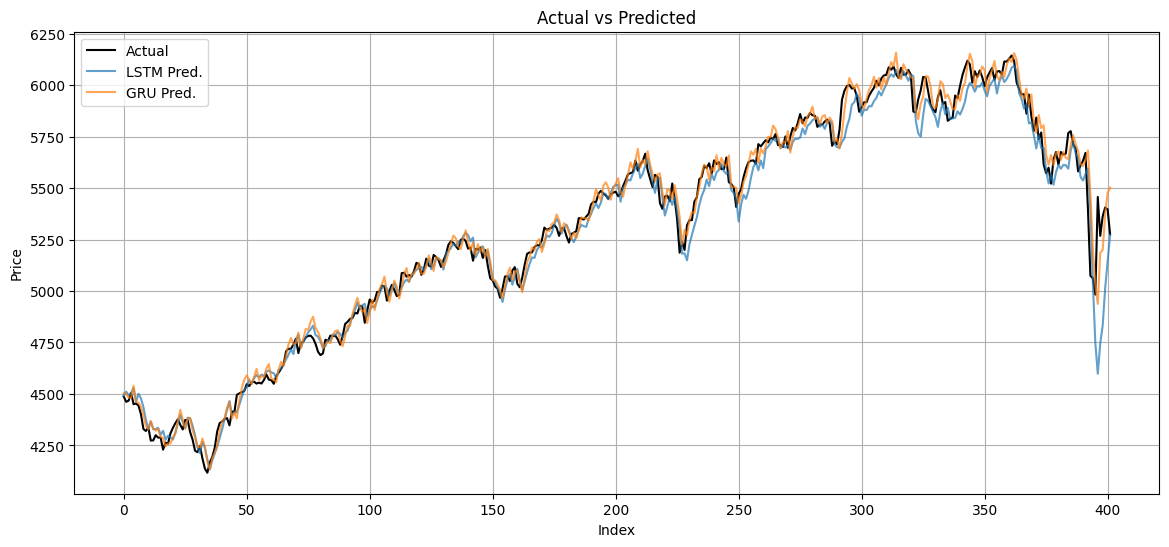

In [118]:
dict_metrics,lstm_pred,gru_pred,y_true1 = evaluate_models_with_price_scaler(
    model_lstm=best_model_lstm,model_gru=best_model_gru,
    X_test=X_test, y_test=y_test,scaler = scaler)

In [112]:
model_dict = {'model': 'predictiong prices using own features',}
new_row = pd.DataFrame([{**model_dict , **dict_metrics}])
model_lst = pd.concat([model_list, new_row], ignore_index=True)
model_lst

,model,mse_lstm,r2_lstm,mse_gru,r2_gru
0,predictiong prices using own features,8243.167418,0.972524,4289.82448,0.985701


In [57]:
metrics_df = pd.DataFrame({'model':["Price - Own Features","Daily Return - XGBoost","Daily Return - RandomForest","Daily Return - Own Features","Daily Return - External Features"],
                           'mse_lstm':[8243.167418,np.nan,np.nan,0.1681,0.0888],
                           'r2_lstm':[0.972524,np.nan,np.nan,0.8994,0.9468],
                           'mse_gru':[4289.82448,np.nan,np.nan,0.1631,0.0592],
                           'r2_gru':[0.985701,np.nan,np.nan,0.9024,0.9646],
                             'mse':[np.nan,0.068583,0.148722,np.nan,np.nan],
                             'r2':[np.nan,0.95818,0.909,np.nan,np.nan]})


metrics_df.head()
metrics_df.to_csv(rf'{directory}/metrics.csv')

In [58]:
metrics_df.head()

,model,mse_lstm,r2_lstm,mse_gru,r2_gru,mse,r2
0,Price - Own Features,8243.167418,0.972524,4289.82448,0.985701,NaN,NaN
1,Daily Return - XGBoost,NaN,NaN,NaN,NaN,0.068583,0.95818
2,Daily Return - RandomForest,NaN,NaN,NaN,NaN,0.148722,0.90900
3,Daily Return - Own Features,0.168100,0.899400,0.16310,0.902400,NaN,NaN
4,Daily Return - External Features,0.088800,0.946800,0.05920,0.964600,NaN,NaN


In [124]:
y_true1.shape

(402, 1)

**Save predictions to csv**

In [125]:
# flatten everything into shape (n,)
lstm_flat = np.squeeze(lstm_pred)  # same as lstm_pred.reshape(-1) or np.ravel(lstm_pred)
gru_flat  = np.squeeze(gru_pred)
act_flat  = np.squeeze(y_true1)

# sanity check
assert lstm_flat.ndim == gru_flat.ndim == act_flat.ndim == 1
assert lstm_flat.shape[0] == gru_flat.shape[0] == act_flat.shape[0]

# build the DataFrame
df1 = pd.DataFrame({
    "Predicted_LSTM": lstm_flat,
    "Predicted_GRU":  gru_flat,
    "Actual":         act_flat
})

# if you have a datetime index array, say `dates`, you can set it here:
# df1.index = pd.to_datetime(dates)

# save to CSV
output_path = f"{directory}/price_own_feat.csv"
df1.to_csv(output_path, index=True)

print(f"Saved DataFrame to {output_path}")


Saved DataFrame to raw_files/price_own_feat.csv


In [17]:
directory

'raw_files'

# Training functions

In [18]:
import joblib

def train_lstm(
    X_train, y_train,X_val, y_val,
    y_scale,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    patience=3,
    checkpoint_path='best_lstm.h5',
    scale_path = f'{directory}/scaler.pkl',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None,
    shuffle=False
):
    """
    Builds, compiles, and trains a multi-layer LSTM model, with optional intermediate Dense and Dropout layers.

    Parameters:
    - X_train, y_train: training data arrays
    - learning_rate: float, optimizer learning rate
    - epochs: int, max training epochs
    - num_layers: int, number of LSTM layers
    - units: tuple of ints, units per LSTM layer (must match num_layers)
    - window_size: int, sequence length (timesteps)
    - batch_size: int
    - validation_split: float, fraction of data for validation
    - patience: int, early stopping patience
    - checkpoint_path: str, filepath to save best model
    - dense_units: int or None, adds Dense layer if specified
    - dense_activation: str, activation for the Dense layer
    - dropout_rate: float or None, adds Dropout after each layer if specified

    Returns:
    - model: trained Keras model
    - history: training history
    """
    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal len(units) ({len(units)})")

    opt = Adam(learning_rate=learning_rate)
    model = Sequential()

    # Add LSTM + optional Dropout
    for i, u in enumerate(units):
        return_seq = (i < num_layers - 1)
        if i == 0:
            model.add(LSTM(u, return_sequences=return_seq,
                           input_shape=(window_size, X_train.shape[2])))
        else:
            model.add(LSTM(u, return_sequences=return_seq))
        if dropout_rate is not None:
            model.add(Dropout(dropout_rate))

    # Optional intermediate Dense + Dropout
    if dense_units is not None:
        model.add(Dense(dense_units, activation=dense_activation))
        if dropout_rate is not None:
            model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    model.compile(optimizer=opt, loss='mse')

    # Callbacks
    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=f'{directory}/{checkpoint_path}',
                          monitor='val_loss',
                          mode = 'min',
                          save_best_only=True,
                          verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[es, chk],
        verbose=1,
        shuffle=shuffle  # Important for time series
    )

    # Save the scaler for future use
    joblib.dump(y_scale, scale_path)

    return model, history


def train_gru(
    X_train, y_train,X_val, y_val,
    y_scale,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    patience=3,
    checkpoint_path='best_lstm.h5',
    scale_path = f'{directory}/scaler.pkl',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None
):
    """
    Builds, compiles, and trains a multi-layer GRU model, with optional intermediate Dense and Dropout layers.

    Same parameters as train_lstm.

    Returns:
    - model: trained Keras model
    - history: training history
    """
    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal len(units) ({len(units)})")

    # Device selection for GPU
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
    with tf.device(device):
        opt = Adam(learning_rate=learning_rate)
        model = Sequential()

        # Add GRU + optional Dropout
        for i, u in enumerate(units):
            return_seq = (i < num_layers - 1)
            if i == 0:
                model.add(GRU(u, return_sequences=return_seq,
                              input_shape=(window_size, X_train.shape[2])))
            else:
                model.add(GRU(u, return_sequences=return_seq))
            if dropout_rate is not None:
                model.add(Dropout(dropout_rate))

        # Optional intermediate Dense + Dropout
        if dense_units is not None:
            model.add(Dense(dense_units, activation=dense_activation))
            if dropout_rate is not None:
                model.add(Dropout(dropout_rate))

        # Output layer
        model.add(Dense(1))
        model.compile(optimizer=opt, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=f'{directory}/{checkpoint_path}',
                          monitor='val_loss',
                          mode = 'min',
                          save_best_only=True,
                          verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),  # Use training data for validation
        callbacks=[es, chk],
        verbose=1
    )
    # Save the scaler for future use
    joblib.dump(y_scale, scale_path)
    
    return model, history


In [175]:
import joblib
import os

def train_lstm(
    X_train, y_train,
    y_scale,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    validation_split=0.2,
    patience=3,
    checkpoint_path=f'{directory}/best_lstm.h5',
    mse_path = f'{directory}/best_lstm_mse.txt',
    scale_path = f'{directory}/scaler.pkl',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None,
    shuffle=False
):
    """
    Builds, compiles, and trains a multi-layer LSTM model, with optional intermediate Dense and Dropout layers.

    Parameters:
    - X_train, y_train: training data arrays
    - learning_rate: float, optimizer learning rate
    - epochs: int, max training epochs
    - num_layers: int, number of LSTM layers
    - units: tuple of ints, units per LSTM layer (must match num_layers)
    - window_size: int, sequence length (timesteps)
    - batch_size: int
    - validation_split: float, fraction of data for validation
    - patience: int, early stopping patience
    - checkpoint_path: str, filepath to save best model
    - dense_units: int or None, adds Dense layer if specified
    - dense_activation: str, activation for the Dense layer
    - dropout_rate: float or None, adds Dropout after each layer if specified

    Returns:
    - model: trained Keras model
    - history: training history
    """
    if os.path.exists(mse_path):
        with open(mse_path,'r') as f:
            best_so_far = float(f.read().strip())
    else:
        best_so_far = np.inf

    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal len(units) ({len(units)})")

    opt = Adam(learning_rate=learning_rate)
    model = Sequential()

    # Add LSTM + optional Dropout
    for i, u in enumerate(units):
        return_seq = (i < num_layers - 1)
        if i == 0:
            model.add(LSTM(u, return_sequences=return_seq,
                           input_shape=(window_size, X_train.shape[2])))
        else:
            model.add(LSTM(u, return_sequences=return_seq))
        if dropout_rate is not None:
            model.add(Dropout(dropout_rate))

    # Optional intermediate Dense + Dropout
    if dense_units is not None:
        model.add(Dense(dense_units, activation=dense_activation))
        if dropout_rate is not None:
            model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    model.compile(optimizer=opt, loss='mse')

    # Callbacks
    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=checkpoint_path,
                          monitor='val_loss',
                          save_best_only=True,
                          baseline=best_so_far,
                          verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[es, chk],
        verbose=1,
        shuffle=shuffle  # Important for time series
    )

    # Save the scaler for future use
    joblib.dump(y_scale, scale_path)

    new_best = min(history.history['val_loss'])
    if new_best < best_so_far:
        with open(mse_path,'w') as f:
            f.write(f"{new_best:.6f}")

    return model, history


def train_gru(
    X_train, y_train,
    y_scale,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    validation_split=0.2,
    patience=3,
    checkpoint_path=f'{directory}/best_lstm.h5',
    scale_path = f'{directory}/scaler.pkl',
    mse_path = f'{directory}/best_gru_mse.txt',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None
):
    
    """
    Builds, compiles, and trains a multi-layer GRU model, with optional intermediate Dense and Dropout layers.

    Same parameters as train_lstm.

    Returns:
    - model: trained Keras model
    - history: training history
    """
    if os.path.exists(mse_path):
        with open(mse_path,'r') as f:
            best_so_far = float(f.read().strip())
    else:
        best_so_far = np.inf


    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal len(units) ({len(units)})")

    # Device selection for GPU
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
    with tf.device(device):
        opt = Adam(learning_rate=learning_rate)
        model = Sequential()

        # Add GRU + optional Dropout
        for i, u in enumerate(units):
            return_seq = (i < num_layers - 1)
            if i == 0:
                model.add(GRU(u, return_sequences=return_seq,
                              input_shape=(window_size, X_train.shape[2])))
            else:
                model.add(GRU(u, return_sequences=return_seq))
            if dropout_rate is not None:
                model.add(Dropout(dropout_rate))

        # Optional intermediate Dense + Dropout
        if dense_units is not None:
            model.add(Dense(dense_units, activation=dense_activation))
            if dropout_rate is not None:
                model.add(Dropout(dropout_rate))

        # Output layer
        model.add(Dense(1))
        model.compile(optimizer=opt, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=checkpoint_path,
                          monitor='val_loss',
                          mode = 'min',
                          save_best_only=True,
                          baseline=best_so_far,
                          verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[es, chk],
        verbose=1
    )
    # Save the scaler for future use
    joblib.dump(y_scale, scale_path)
    
    new_best = min(history.history['val_loss'])
    if new_best < best_so_far:
        with open(mse_path,'w') as f:
            f.write(f"{new_best:.6f}")

    return model, history


### plotting for each epoch
Function to plot the loss per epoch 

In [19]:
def plot_training_history(history, title="Model Loss"):
    """
    Plots training & validation loss curves from a Keras History object.
    
    history: the History returned by model.fit(...)
    title:   optional title for the plot
    """
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'o-', label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(epochs, history.history['val_loss'], 's--', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

### LSTM

In [206]:
model_lstm = train_lstm(
    X_train, y_train,X_test, y_test,
    y_scale,
    learning_rate=0.003,
    epochs=30,
    num_layers=1,
    units=(64,),
    window_size=30,
    batch_size=32,
    patience=5,
    checkpoint_path='_best_lstm.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate = None,
)[0]

Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109
Epoch 1: val_loss improved from inf to 0.09112, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0108 - val_loss: 0.0911
Epoch 2/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0344
Epoch 2: val_loss improved from 0.09112 to 0.07829, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0333 - val_loss: 0.0783
Epoch 3/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113
Epoch 3: val_loss improved from 0.07829 to 0.05636, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0110 - val_loss: 0.0564
Epoch 4/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081
Epoch 4: val_loss improved from 0.05636 to 0.05102, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0079 - val_loss: 0.0510
Epoch 5/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075
Epoch 5: val_loss did not improve from 0.05102
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0074 - val_loss: 0.0512
Epoch 6/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072
Epoch 6: val_loss improved from 0.05102 to 0.05081, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0071 - val_loss: 0.0508
Epoch 7/30
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069
Epoch 7: val_loss improved from 0.05081 to 0.05056, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0066 - val_loss: 0.0506
Epoch 8/30
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 
Epoch 8: val_loss improved from 0.05056 to 0.05012, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0062 - val_loss: 0.0501
Epoch 9/30
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060
Epoch 9: val_loss improved from 0.05012 to 0.04956, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0057 - val_loss: 0.0496
Epoch 10/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055
Epoch 10: val_loss improved from 0.04956 to 0.04817, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0054 - val_loss: 0.0482
Epoch 11/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047
Epoch 11: val_loss improved from 0.04817 to 0.04613, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0047 - val_loss: 0.0461
Epoch 12/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045
Epoch 12: val_loss improved from 0.04613 to 0.04428, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0044 - val_loss: 0.0443
Epoch 13/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044
Epoch 13: val_loss did not improve from 0.04428
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0043 - val_loss: 0.0452
Epoch 14/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045
Epoch 14: val_loss did not improve from 0.04428
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0045 - val_loss: 0.0458
Epoch 15/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045
Epoch 15: val_loss did not improve from 0.04428
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0044 - val_loss: 0.0447
Epoch 16/30
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046
Epoch 16: val_loss improved from 0.04428 to 0.04361, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0045 - val_loss: 0.0436
Epoch 17/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047
Epoch 17: val_loss did not improve from 0.04361
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0047 - val_loss: 0.0446
Epoch 18/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047
Epoch 18: val_loss improved from 0.04361 to 0.03960, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0047 - val_loss: 0.0396
Epoch 19/30
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047
Epoch 19: val_loss improved from 0.03960 to 0.03705, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0047 - val_loss: 0.0370
Epoch 20/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049
Epoch 20: val_loss improved from 0.03705 to 0.03566, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049 - val_loss: 0.0357
Epoch 21/30
45/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047
Epoch 21: val_loss improved from 0.03566 to 0.03364, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0047 - val_loss: 0.0336
Epoch 22/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042
Epoch 22: val_loss improved from 0.03364 to 0.02677, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0042 - val_loss: 0.0268
Epoch 23/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038
Epoch 23: val_loss improved from 0.02677 to 0.02458, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0038 - val_loss: 0.0246
Epoch 24/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030
Epoch 24: val_loss improved from 0.02458 to 0.02134, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - val_loss: 0.0213
Epoch 25/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020
Epoch 25: val_loss improved from 0.02134 to 0.01988, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_loss: 0.0199
Epoch 26/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011    
Epoch 26: val_loss improved from 0.01988 to 0.01840, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0184
Epoch 27/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011    
Epoch 27: val_loss improved from 0.01840 to 0.01771, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0177
Epoch 28/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.3512e-04
Epoch 28: val_loss improved from 0.01771 to 0.01705, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.0506e-04 - val_loss: 0.0171
Epoch 29/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7163e-04
Epoch 29: val_loss improved from 0.01705 to 0.01652, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.3793e-04 - val_loss: 0.0165
Epoch 30/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5920e-04
Epoch 30: val_loss improved from 0.01652 to 0.01610, saving model to raw_files/_best_lstm.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.0078e-04 - val_loss: 0.0161


### GRU

In [207]:
model_gru = train_gru(
    X_train, y_train,X_test, y_test,
    y_scale,
    learning_rate=0.003,
    epochs=30,
    num_layers=1,
    units=(92,),
    window_size=30,
    batch_size=32,
    patience=5,
    checkpoint_path='_best_gru.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate= None
)[0]

Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0272
Epoch 1: val_loss improved from inf to 0.00094, saving model to raw_files/_best_gru.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0266 - val_loss: 9.4477e-04
Epoch 2/30
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2483e-04
Epoch 2: val_loss improved from 0.00094 to 0.00034, saving model to raw_files/_best_gru.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.1655e-04 - val_loss: 3.3571e-04
Epoch 3/30
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9313e-04
Epoch 3: val_loss improved from 0.00034 to 0.00032, saving model to raw_files/_best_gru.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9227e-04 - val_loss: 3.2274e-04
Epoch 4/30
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6802e-04
Epoch 4: val_loss did not improve from 0.00032
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6769e-04 - val_loss: 3.2487e-04
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5743e-04
Epoch 5: val_loss did not improve from 0.00032
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5738e-04 - val_loss: 3.5482e-04
Epoch 6/30
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5459e-04
Epoch 6: val_loss did not improve from 0.00032
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5413e-04 - val_loss: 3.6264e-04
Epoch 7/30
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5186e-04
Epoch 7: val_loss did not improve from 0.00032
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5160e-04 - val_loss: 3.8768e-04
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5167e-04
Epoch 8: val_loss did not improve from 0.00032
51/51

### Load the best model

In [23]:
from tensorflow.keras.models import load_model

def load_best_model(checkpoint_path,X_test,scaler):
    """
    Load the best model from a given checkpoint path.
    
    Parameters:
    - checkpoint_path: str, path to the saved model file (e.g., 'best_lstm.h5')
    
    Returns:
    - best_model: Keras model loaded from the checkpoint
    """
    # 2. Load the entire model (architecture + weights + optimizer state)
    best_model = load_model(checkpoint_path, compile=False)
    # 3. Load the scaler
    y_scaler = joblib.load(f'{directory}/{scaler}')  
    # 3. Now you can call .predict(), .evaluate(), etc.
    preds_scaled = best_model.predict(X_test)
    # 4. Inverse transform the predictions if needed
    #price_scaler = MinMaxScaler()
    #price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
    #preds_scaled = price_scaler.inverse_transform(preds)

    preds = y_scaler.inverse_transform(preds_scaled)

    return preds ,best_model,y_scaler


## Making a prediction and inversing the scale:

LSTM - MSE: 5045.6500, R²: 0.9831

GRU  - MSE: 5646.8779, R²: 0.9811

In [158]:
preds_lstm , best_lstm , y_scaler = load_best_model('_best_lstm.h5',X_test,'scaler.pkl')

preds_gru , best_gru,y_scaler = load_best_model('_best_gru.h5',X_test,'scaler.pkl')


y_test_actual = y_scale.inverse_transform(y_test.reshape(-1, 1))

mse_gru = mean_squared_error(y_test_actual, preds_gru)
r2_gru = r2_score(y_test_actual, preds_gru)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [159]:
print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')

GRU  - MSE: 8547.9346, R²: 0.9715


## **1 Check the model using own features**

In [37]:
split = split = int(0.8 * len(X))
dates = result.index[window_size + split:]

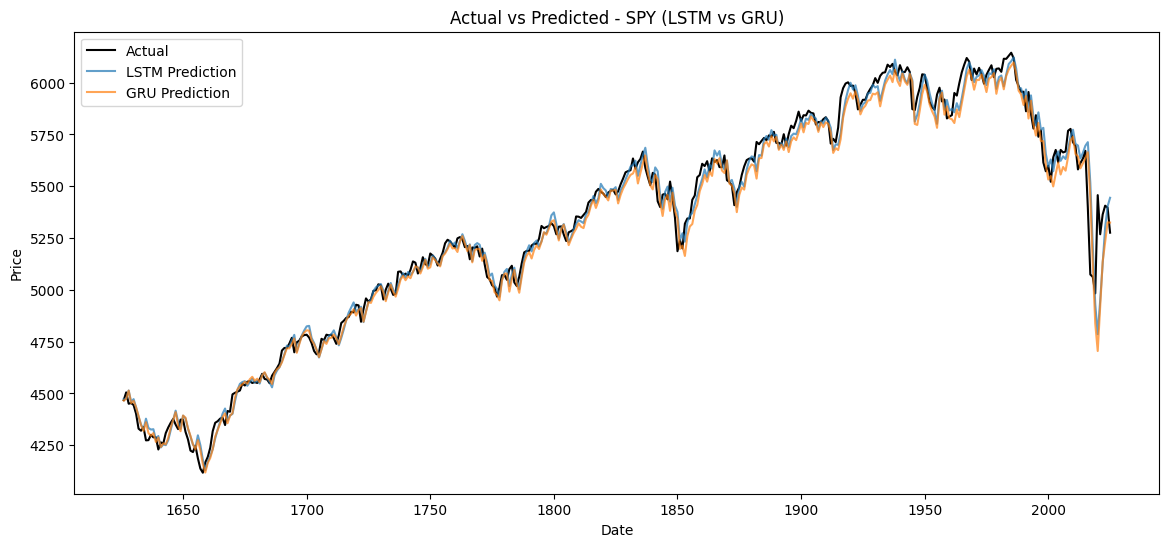

In [133]:
ticker = 'SPY'
plt.figure(figsize=(14,6))
plt.plot(dates, y_test_actual, label='Actual', color='black')
plt.plot(dates, pred_lstm, label='LSTM Prediction', alpha=0.7)
plt.plot(dates, pred_gru, label='GRU Prediction', alpha=0.7)
plt.title(f'Actual vs Predicted - {ticker} (LSTM vs GRU)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(False)
plt.show()

# Add external other financial instruments as features

In [20]:
print(SPY.columns.to_list())
#SPY['^VIX'].head()
all_features = SPY.columns.to_list() # test all of the features 

['ds', 'SPY_Close', 'SPY_Volume', 'AAPL', 'MSFT', 'GOOG', 'GLD', 'SLV', '^TNX', 'DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO', 'UNG', 'BTC-USD', 'CPER', '^VIX', '^GDAXI', '^FTSE', '^RUT', '^N225', 'IEI', 'CNYUSD=X', '2Y_Yield', 'yield_curve', 'market_closed_count', 'yield_curve_term', 'high-low', 'before_high-low', 'SPY_RSI', 'RSI_rank', 'RSI_rank_2', 'EMA_20', 'EMA_50', 'EMA_200', 'EMA_20_50', 'EMA_50_200', 'EMA_50_diff', 'EMA_200_diff', 'SPY_std', 'SPY_mean', 'SPY_30', 'QQQ_Close', 'QQQ_Volume', 'qqq_std', 'qqq_mean']


In [38]:
col_list = []
result2 = model_own_features(
    data=SPY,
    column='SPY_Close',
    keep_columns=['SPY_Close','high-low','before_high-low','SPY_Volume','QQQ_Close','GOOG','AAPL','CPER','^VIX','^RUT','yield_curve','EMA_50', 'EMA_200','^FTSE','ds']
)
#['SPY_Close','high-low','before_high-low','SPY_Volume','QQQ_Close','GOOG','AAPL','CPER','^VIX','^RUT','yield_curve','EMA_50', 'EMA_200','IEI','^GDAXI', '^FTSE','ds']
result2['abs_consecutive_change'] = calculate_consecutive_return(result2['SPY_Close'], result2['streak'])
result2 = date_features(result2) # to add date features
result2 = result2.merge(spy_zones[['ds','SUPPORT_Signal','RESISTANCE_Signal']], on='ds', how='left') # optional : add support and resistance areas
result2 = result2.drop('ds', axis=1) # drop the date column
result2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SPY_Close               2036 non-null   float64
 1   high-low                2036 non-null   float64
 2   before_high-low         2036 non-null   float64
 3   SPY_Volume              2036 non-null   int64  
 4   QQQ_Close               2036 non-null   float64
 5   GOOG                    2036 non-null   float64
 6   AAPL                    2036 non-null   float64
 7   CPER                    2036 non-null   float64
 8   ^VIX                    2036 non-null   float64
 9   ^RUT                    2036 non-null   float64
 10  yield_curve             2036 non-null   float64
 11  EMA_50                  2036 non-null   float64
 12  EMA_200                 2036 non-null   float64
 13  ^FTSE                   2036 non-null   float64
 14  RSI_14                  2036 non-null   

In [39]:
#print(result2.columns.to_list())
result2.reset_index(drop=True)
result2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SPY_Close               2036 non-null   float64
 1   high-low                2036 non-null   float64
 2   before_high-low         2036 non-null   float64
 3   SPY_Volume              2036 non-null   int64  
 4   QQQ_Close               2036 non-null   float64
 5   GOOG                    2036 non-null   float64
 6   AAPL                    2036 non-null   float64
 7   CPER                    2036 non-null   float64
 8   ^VIX                    2036 non-null   float64
 9   ^RUT                    2036 non-null   float64
 10  yield_curve             2036 non-null   float64
 11  EMA_50                  2036 non-null   float64
 12  EMA_200                 2036 non-null   float64
 13  ^FTSE                   2036 non-null   float64
 14  RSI_14                  2036 non-null   

### prepare the data

In [54]:
window_size = 30
X_train, X_test, y_train, y_test,X,y_scale = prepare_RNN_data(result2, window_size,scaler)

### Search for the best hyperparameters using the added features

### GRU

In [55]:
best_model_gru2, best_loss_gru2, best_cfg_gru2 = search_best_model(
    model_type="GRU",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size, # None since we reshape to (samples, 1, features)
    path= 'gru_with_feat1.keras',
    layer_options=[1,2,3],
    unit_options=[128,256,96],
    epochs=30,
    batch_size=32,
    patience=5,
    learning_rates=(0.001,),
    dense_units = None,
    dense_activation='relu',
    dropout_rate=None
)
print("Best loss:", best_loss_gru2, "Config:", best_cfg_gru2)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.0013703553704544902 Config: {'model_type': 'GRU', 'n_layers': 2, 'units': (96, 256), 'learning_rate': 0.001, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': None}


In [27]:
#pred_lstm = model_lstm.predict(X_test)
pred_gru = best_model_gru2.predict(X_test)

# reset the scaler to the original price range
price_scaler = MinMaxScaler()
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
#pred_lstm = price_scaler.inverse_transform(pred_lstm)
pred_gru = price_scaler.inverse_transform(pred_gru)
y_test_actual = price_scaler.inverse_transform(y_test.reshape(-1, 1))
#y_test_actual = price_scaler.inverse_transform(y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [29]:
#mse_lstm = mean_squared_error(y_test_actual, pred_lstm)
mse_gru = mean_squared_error(y_test_actual, pred_gru)

#r2_lstm = r2_score(y_test_actual, pred_lstm)
r2_gru = r2_score(y_test_actual, pred_gru)

#print(f'LSTM - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}')
print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')

GRU  - MSE: 789.4322, R²: 0.9414


### train the models

Epoch 1/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0481
Epoch 1: val_loss improved from inf to 0.00696, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0463 - val_loss: 0.0070
Epoch 2/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.7225e-04
Epoch 2: val_loss improved from 0.00696 to 0.00264, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.6894e-04 - val_loss: 0.0026
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9662e-04
Epoch 3: val_loss improved from 0.00264 to 0.00262, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9665e-04 - val_loss: 0.0026
Epoch 4/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8279e-04
Epoch 4: val_loss improved from 0.00262 to 0.00253, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.8298e-04 - val_loss: 0.0025
Epoch 5/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7890e-04
Epoch 5: val_loss improved from 0.00253 to 0.00210, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7894e-04 - val_loss: 0.0021
Epoch 6/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7811e-04
Epoch 6: val_loss improved from 0.00210 to 0.00181, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7821e-04 - val_loss: 0.0018
Epoch 7/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7623e-04
Epoch 7: val_loss improved from 0.00181 to 0.00154, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7664e-04 - val_loss: 0.0015
Epoch 8/30
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7498e-04
Epoch 8: val_loss improved from 0.00154 to 0.00121, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7568e-04 - val_loss: 0.0012
Epoch 9/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6766e-04
Epoch 9: val_loss improved from 0.00121 to 0.00103, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.6801e-04 - val_loss: 0.0010
Epoch 10/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5687e-04
Epoch 10: val_loss improved from 0.00103 to 0.00096, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5714e-04 - val_loss: 9.6341e-04
Epoch 11/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5295e-04
Epoch 11: val_loss improved from 0.00096 to 0.00093, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5331e-04 - val_loss: 9.2779e-04
Epoch 12/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5383e-04
Epoch 12: val_loss improved from 0.00093 to 0.00089, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5413e-04 - val_loss: 8.9370e-04
Epoch 13/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5571e-04
Epoch 13: val_loss improved from 0.00089 to 0.00079, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5607e-04 - val_loss: 7.8953e-04
Epoch 14/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5660e-04
Epoch 14: val_loss improved from 0.00079 to 0.00069, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5713e-04 - val_loss: 6.9192e-04
Epoch 15/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5774e-04
Epoch 15: val_loss improved from 0.00069 to 0.00061, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5814e-04 - val_loss: 6.0854e-04
Epoch 16/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6077e-04
Epoch 16: val_loss improved from 0.00061 to 0.00057, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.6104e-04 - val_loss: 5.7062e-04
Epoch 17/30
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6326e-04
Epoch 17: val_loss improved from 0.00057 to 0.00054, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.6350e-04 - val_loss: 5.3972e-04
Epoch 18/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6627e-04
Epoch 18: val_loss improved from 0.00054 to 0.00054, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.6645e-04 - val_loss: 5.3662e-04
Epoch 19/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6634e-04
Epoch 19: val_loss did not improve from 0.00054
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6655e-04 - val_loss: 5.4088e-04
Epoch 20/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6600e-04
Epoch 20: val_loss improved from 0.00054 to 0.00053, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6616e-04 - val_loss: 5.2835e-04
Epoch 21/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6510e-04
Epoch 21: val_loss improved from 0.00053 to 0.00053, saving model to raw_files/best_gru_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.6539e-04 - val_loss: 5.2772e-04
Epoch 22/30
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6315e-04
Epoch 22: val_loss did not improve from 0.00053
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6363e-04 - val_loss: 5.4679e-04
Epoch 23/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6097e-04
Epoch 23: val_loss did not improve from 0.00053
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6140e-04 - val_loss: 5.5477e-04
Epoch 24/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6004e-04
Epoch 24: val_loss did not improve from 0.00053
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6052e-04 - val_loss: 5.4455e-04


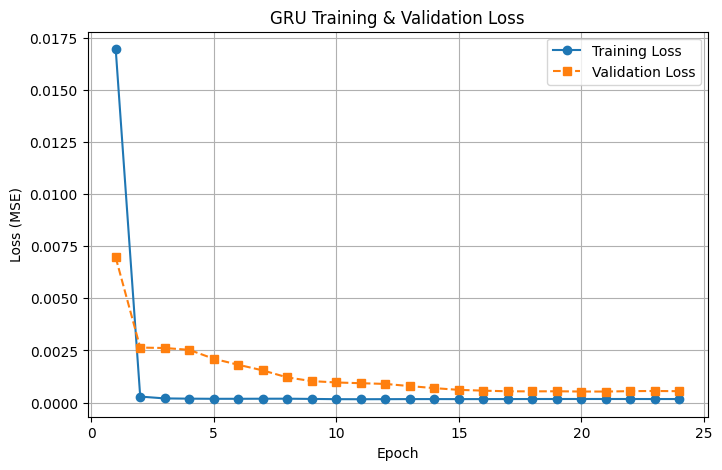

In [ ]:
model_gru , history= train_gru(
    X_train, y_train,X_test, y_test,
    y_scale,
    learning_rate=0.002,
    epochs=30,
    num_layers=1,
    units=(256,),
    window_size=window_size,
    batch_size=32,
    patience=3,
    checkpoint_path='best_gru_with_feat.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None
    
)

# 2) Plot
plot_training_history(history, title="GRU Training & Validation Loss")

### LSTM

In [36]:
best_model_lstm2, best_loss_lstm2, best_cfg_lstm2 = search_best_model(
    model_type="LSTM",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size, # None since we reshape to (samples, 1, features)
    path= 'best_price_lstm_ext.keras',
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=25,
    batch_size=32,
    patience=3,
    learning_rates=(0.004,0.005),
    dense_units = None,
    dense_activation='relu',
    dropout_rate=None
)
print("Best loss:", best_loss_lstm2, "Config:", best_cfg_lstm2)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.00042799775837920606 Config: {'model_type': 'LSTM', 'n_layers': 2, 'units': (64, 92), 'learning_rate': 0.004, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': None}


In [367]:
model_lstm = train_lstm(
    X_train, y_train,X_test, y_test,
    y_scale,
    learning_rate=0.004,
    epochs=30,
    num_layers=1,
    units=(92,),
    window_size=window_size,
    batch_size=32,
    patience=5,
    checkpoint_path='best_lstm_with_feat.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None
)[0]

Epoch 1/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0740
Epoch 1: val_loss improved from inf to 0.02730, saving model to raw_files/best_lstm_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0713 - val_loss: 0.0273
Epoch 2/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0274
Epoch 2: val_loss improved from 0.02730 to 0.01512, saving model to raw_files/best_lstm_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0265 - val_loss: 0.0151
Epoch 3/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0012
Epoch 3: val_loss did not improve from 0.01512
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0012 - val_loss: 0.0174
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.1584e-04
Epoch 4: val_loss improved from 0.01512 to 0.01282, saving model to raw_files/best_lstm_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 8.1422e-04 - val_loss: 0.0128
Epoch 5/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.7161e-04
Epoch 5: val_loss improved from 0.01282 to 0.00990, saving model to raw_files/best_lstm_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.8118e-04 - val_loss: 0.0099
Epoch 6/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.8173e-04
Epoch 6: val_loss improved from 0.00990 to 0.00956, saving model to raw_files/best_lstm_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.9579e-04 - val_loss: 0.0096
Epoch 7/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.4372e-04
Epoch 7: val_loss improved from 0.00956 to 0.00948, saving model to raw_files/best_lstm_with_feat.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.5437e-04 - val_loss: 0.0095
Epoch 8/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.8431e-04
Epoch 8: val_loss did not improve from 0.00948
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.0020e-04 - val_loss: 0.0097
Epoch 9/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.0813e-04
Epoch 9: val_loss did not improve from 0.00948
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.1618e-04 - val_loss: 0.0106
Epoch 10/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.0733e-04
Epoch 10: val_loss did not improve from 0.00948
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.2337e-04 - val_loss: 0.0109
Epoch 11/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.4746e-04
Epoch 11: val_loss did not improve from 0.00948
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.4819e-04 - val_loss: 0.0122
Epoch 12/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.4602e-04
Epoch 12: val_loss did not improve from 0.00948
51/51 ━━━━━━━━━━━━━

**Evaluate the model with the added features**

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
LSTM → MSE: 12059.7840,   R²: 0.9598
GRU  → MSE: 5239.5252,   R²: 0.9825


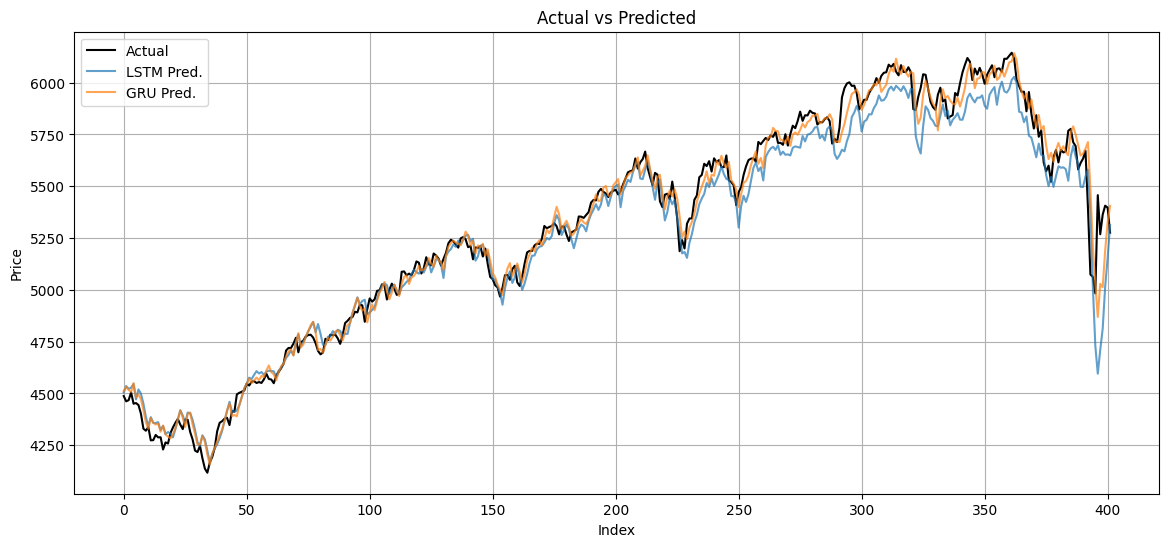

{'mse_lstm': 12059.783968969958,
 'r2_lstm': 0.9598024636111175,
 'mse_gru': 5239.525210489088,
 'r2_gru': 0.9825356734539341}

In [ ]:
evaluate_models_with_price_scaler(model_lstm=model_lstm, model_gru=model_gru,
                                  X_test=X_test, y_test=y_test, scaler=scaler)


### 2 **Check the models with addea features**

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM → MSE: 1772.4352,   R²: 0.8684
GRU  → MSE: 789.4323,   R²: 0.9414


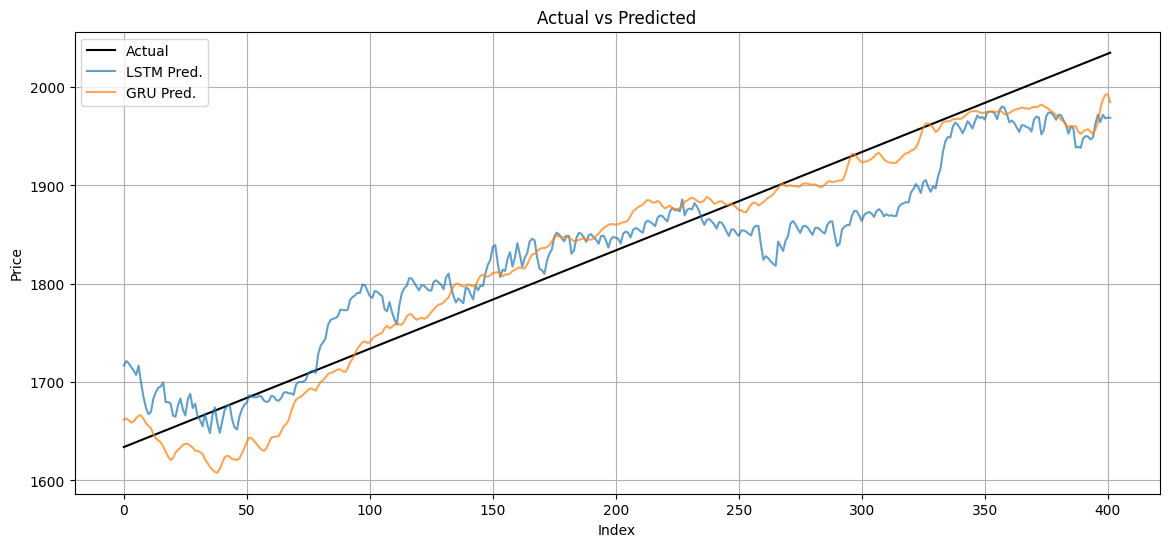

In [37]:
abs_result = evaluate_models_with_price_scaler(
    model_lstm=best_model_lstm2,
    model_gru=best_model_gru2,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler
)

In [273]:
from sklearn.inspection import permutation_importance

# assuming `model` is your trained LSTM wrapped for sklearn-like API, and X_val, y_val are your validation sets:
r = permutation_importance(
    best_model_gru2, X_test, y_test,
    n_repeats=5,
    scoring='neg_mean_squared_error',
    random_state=0
)

importances = r.importances_mean
feature_ranking = np.argsort(importances)[::-1]
print("Top features:", feature_names[feature_ranking[:10]])


ValueError: Found array with dim 3. None expected <= 2.

# Add external data (economic data)

In [24]:
external_data = pd.read_pickle(r'raw_files/external_data.pkl')
external_data.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2592 non-null   datetime64[ns]
 1   Actual_GDP                     204 non-null    float64       
 2   Actual_nonfarm                 206 non-null    float64       
 3   Actual_CPI                     155 non-null    float64       
 4   Actual_PPI                     170 non-null    float64       
 5   Actual_unemployment rate       201 non-null    float64       
 6   Actual_core_PCE                125 non-null    float64       
 7   Actual_FOMC                    139 non-null    float64       
 8   CPI_vs_forecast                155 non-null    float64       
 9   CPI_vs_previous                155 non-null    float64       
 10  GDP_vs_forecast                204 non-null    float64       
 11  GDP_vs_previous  

In [25]:
#external_data.iloc[145:155]
external_data.fillna(method='ffill', inplace=True)
external_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2592 non-null   datetime64[ns]
 1   Actual_GDP                     2592 non-null   float64       
 2   Actual_nonfarm                 2591 non-null   float64       
 3   Actual_CPI                     2443 non-null   float64       
 4   Actual_PPI                     2499 non-null   float64       
 5   Actual_unemployment rate       2580 non-null   float64       
 6   Actual_core_PCE                2308 non-null   float64       
 7   Actual_FOMC                    2590 non-null   float64       
 8   CPI_vs_forecast                2443 non-null   float64       
 9   CPI_vs_previous                2443 non-null   float64       
 10  GDP_vs_forecast                2592 non-null   float64       
 11  GDP_vs_previous  

C:\Users\OMER\AppData\Local\Temp\ipykernel_9556\2534430223.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  external_data.fillna(method='ffill', inplace=True)


In [220]:
# print to see all of the data available 
lst_ = external_data.columns.to_list()
l = [col for col in lst_ if col.endswith('vs_forecast')]
print(l)
print(lst_[7:15])

['CPI_vs_forecast', 'GDP_vs_forecast', 'PPI_vs_forecast', 'nonfarm_vs_forecast', 'unemployment rate_vs_forecast', 'core_PCE_vs_forecast', 'FOMC_vs_forecast']
['Actual_FOMC', 'CPI_vs_forecast', 'CPI_vs_previous', 'GDP_vs_forecast', 'GDP_vs_previous', 'PPI_vs_forecast', 'PPI_vs_previous', 'nonfarm_vs_forecast']


### Prepare the new data for modeling

In [221]:
col_list = ['SPY_Close','high-low','before_high-low','SPY_Volume','QQQ_Close','CPER','^VIX','^RUT','yield_curve','EMA_50', 'EMA_200','IEI','^GDAXI', '^FTSE','DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO','ds']
ext_cols = l#lst_[7:15]
ext_cols.append('ds') # add the date column
result3 = model_own_features(data= SPY , column='SPY_Close', keep_columns=col_list)
# Now merge 
result3 = result3.merge(external_data[ext_cols], on='ds', how='left')
result3 = result3.drop('ds',axis=1) # drop the date column
result3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2038 entries, 0 to 2037
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SPY_Close                      2038 non-null   float64
 1   high-low                       2038 non-null   float64
 2   before_high-low                2038 non-null   float64
 3   SPY_Volume                     2038 non-null   int64  
 4   QQQ_Close                      2038 non-null   float64
 5   CPER                           2038 non-null   float64
 6   ^VIX                           2038 non-null   float64
 7   ^RUT                           2038 non-null   float64
 8   yield_curve                    2038 non-null   float64
 9   EMA_50                         2038 non-null   float64
 10  EMA_200                        2038 non-null   float64
 11  IEI                            2038 non-null   float64
 12  ^GDAXI                         2038 non-null   f

In [222]:
window_size = 30
X_train, X_test, y_train, y_test,X = prepare_RNN_data(result3, 30,scaler)

In [ ]:
best_gru_econ, best_loss_gru_econ, best_cfg_gru_econ, = search_best_model(
    model_type="GRU",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size, # None since we reshape to (samples, 1, features)
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=25,
    batch_size=32,
    patience=5,
    learning_rates=(0.004,0.003),
    dense_units = None,
    dense_activation='relu',
    dropout_rate=0.1
)
print("Best loss:", best_loss_gru_econ, "Config:", best_cfg_gru_econ)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.0010562548413872719 Config: {'model_type': 'GRU', 'n_layers': 1, 'units': (32,), 'learning_rate': 0.004, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': 0.1}


Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0955
Epoch 1: val_loss improved from inf to 0.03136, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0935 - val_loss: 0.0314
Epoch 2/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0111
Epoch 2: val_loss improved from 0.03136 to 0.00909, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 3/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056
Epoch 3: val_loss improved from 0.00909 to 0.00674, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 4/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0048
Epoch 4: val_loss improved from 0.00674 to 0.00214, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 5/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041
Epoch 5: val_loss did not improve from 0.00214
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0033
Epoch 6: val_loss improved from 0.00214 to 0.00169, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 7/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026
Epoch 7: val_loss improved from 0.00169 to 0.00047, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026 - val_loss: 4.6952e-04
Epoch 8/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022
Epoch 8: val_loss did not improve from 0.00047
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 9/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024
Epoch 9: val_loss did not improve from 0.00047
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 10/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017
Epoch 10: val_loss did not improve from 0.00047
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 11/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
Epoch 11: val_loss improved from 0.00047 to 0.00041, saving model to best_gru_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 4.0722e-04
Epoch 12/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017
Epoch 12: val_loss did not improve from 0.00041
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 13/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
Epoch 13: val_loss did not improve from 0.00041
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - val_loss: 4.2149e-04
Epoch 14/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
Epoch 14: val_loss did not improve from 0.00041
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 15/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010
Epoch 15: val_loss did not improve from 0.00041
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 16/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
Epoch 16: val_loss did not improve from 0.00041
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss:

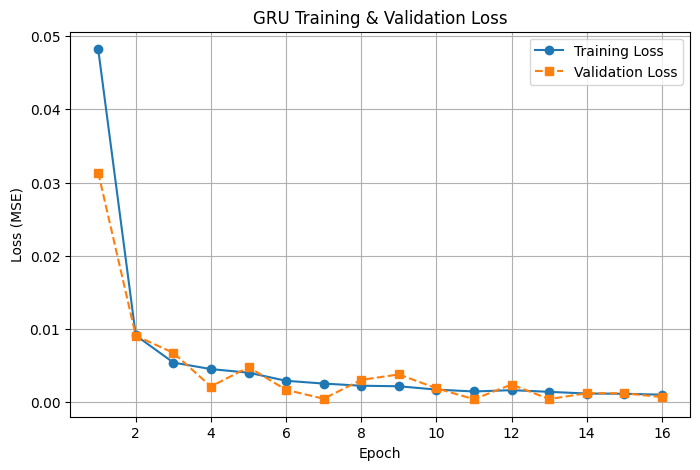

In [216]:
model_gru , history= train_gru(
    X_train, y_train,
    learning_rate=0.004,
    epochs=30,
    num_layers=1,
    units=(32,),
    window_size=window_size,
    batch_size=32,
    validation_split=0.1,
    patience=5,
    checkpoint_path='best_gru_with_external.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=0.1
)

# 2) Plot
plot_training_history(history, title="GRU Training & Validation Loss")

In [ ]:
best_lstm_econ, best_loss_lstm_econ, best_cfg_lstm_econ = search_best_model(
    model_type="LSTM",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size, # None since we reshape to (samples, 1, features)
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=25,
    batch_size=32,
    patience=5,
    learning_rates=(0.003,),
    dense_units = None,
    dense_activation='relu',
    dropout_rate=0.1
)
print("Best loss:", best_loss_lstm_econ, "Config:", best_cfg_lstm_econ)

In [217]:
model_lstm = train_lstm(
    X_train, y_train,
    learning_rate=0.004,
    epochs=30,
    num_layers=1,
    units=(64,),
    window_size=window_size,
    batch_size=32,
    validation_split=0.1,
    patience=5,
    checkpoint_path='best_lstm_with_external.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None
)[0]

Epoch 1/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0503
Epoch 1: val_loss improved from inf to 0.01122, saving model to best_lstm_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0493 - val_loss: 0.0112
Epoch 2/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0452
Epoch 2: val_loss improved from 0.01122 to 0.00944, saving model to best_lstm_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0443 - val_loss: 0.0094
Epoch 3/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0231
Epoch 3: val_loss improved from 0.00944 to 0.00115, saving model to best_lstm_with_external.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0224 - val_loss: 0.0012
Epoch 4/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0224
Epoch 4: val_loss did not improve from 0.00115
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0219 - val_loss: 0.0033
Epoch 5/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0253
Epoch 5: val_loss did not improve from 0.00115
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0247 - val_loss: 0.0046
Epoch 6/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0110
Epoch 6: val_loss did not improve from 0.00115
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0108 - val_loss: 0.0072
Epoch 7/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0070
Epoch 7: val_loss did not improve from 0.00115
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0070 - val_loss: 0.0051
Epoch 8/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0173
Epoch 8: val_loss did not improve from 0.00115
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0170 - val_loss

In [218]:
abs_result = evaluate_models_with_price_scaler(
    model_lstm=model_lstm,
    model_gru=model_gru,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler
)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM - MSE: 993589.0234, R²: -2.3118
GRU  - MSE: 84905.8412, R²: 0.7170


# **Forcasting return data**

In [202]:
return_data = pd.read_pickle(rf'{directory}/df_with_QQQ.pkl')
return_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 67 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   QQQ_Close            2071 non-null   float64       
 1   ^RUT                 2071 non-null   float64       
 2   ^VIX                 2071 non-null   float64       
 3   EMA_20               2071 non-null   float64       
 4   avgreturn5d          2071 non-null   float64       
 5   ^GDAXI               2071 non-null   float64       
 6   stdev_5              2071 non-null   float64       
 7   qqq_mean             2071 non-null   float64       
 8   GOOG                 2071 non-null   float64       
 9   MSFT                 2071 non-null   float64       
 10  ^FTSE                2071 non-null   float64       
 11  AAPL                 2071 non-null   float64       
 12  std_price            2071 non-null   float64       
 13  abs_yield_curve      2071 non-nul

In [203]:
print(return_data.columns.to_list())
return_data = return_data.reindex(columns=["SPY_return"] + list(return_data.columns.drop("SPY_return")))

['QQQ_Close', '^RUT', '^VIX', 'EMA_20', 'avgreturn5d', '^GDAXI', 'stdev_5', 'qqq_mean', 'GOOG', 'MSFT', '^FTSE', 'AAPL', 'std_price', 'abs_yield_curve', 'high-low', 'UNG', 'stdev', 'abs_vix', 'SLV', '^TNX', 'EMA_200', 'BTC-USD', 'EMA_50', 'USO', 'CPER', 'JPY=X', 'CNYUSD=X', 'before_high-low', 'SPY_RSI', 'GLD', 'IWM_avg5d', 'shiler pe', 'SPY_Volume', 'abs_vol', '^N225', 'SPY_AbsChange', 'avgreturn10d', 'IEI', 'Yestrady', 'abs_2Y_Yield', 'DX-Y.NYB', 'JPY', 'EUR=X', 'yield_curve', 'IWM_std_5d', 'days_since_fomc', 'qqq_std', '2Y_Yield', 'EUR', 'QQQ_Volume', 'DXY', 'day', 'Monday', 'Actual_GDP', 'vol_above_mean', 'Actual_FOMC', 'SPY_Streak', 'Actual_CPI', 'Tuesday', '^VIX_rank', 'market_closed_count', 'Wednesday', 'May', 'GDP_vs_forecast', 'February', 'ds', 'SPY_return']


### Add MACD data

In [204]:
result1 = model_own_features(
    data=SPY,
    column='SPY_Close',
    keep_columns=['SPY_Close','high-low','before_high-low','ds']
)

In [205]:
result1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2036 entries, 19 to 2054
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SPY_Close        2036 non-null   float64       
 1   high-low         2036 non-null   float64       
 2   before_high-low  2036 non-null   float64       
 3   ds               2036 non-null   datetime64[ns]
 4   RSI_14           2036 non-null   float64       
 5   MACD             2036 non-null   float64       
 6   20d_mean         2036 non-null   float64       
 7   5d_mean          2036 non-null   float64       
 8   5d_std           2036 non-null   float64       
 9   streak           2036 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 175.0 KB


In [206]:
#Merge
return_data1 = return_data.merge(result1[['ds','RSI_14','MACD','streak']], on='ds', how='inner')

# Add features for seasonality 

In [208]:

return_data1['month'] = return_data1['ds'].dt.month
return_data1['day_of_week'] = return_data1['ds'].dt.dayofweek
return_data1['day_of_week'] = return_data1['day_of_week'] + 2
return_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 72 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SPY_return           2036 non-null   float64       
 1   QQQ_Close            2036 non-null   float64       
 2   ^RUT                 2036 non-null   float64       
 3   ^VIX                 2036 non-null   float64       
 4   EMA_20               2036 non-null   float64       
 5   avgreturn5d          2036 non-null   float64       
 6   ^GDAXI               2036 non-null   float64       
 7   stdev_5              2036 non-null   float64       
 8   qqq_mean             2036 non-null   float64       
 9   GOOG                 2036 non-null   float64       
 10  MSFT                 2036 non-null   float64       
 11  ^FTSE                2036 non-null   float64       
 12  AAPL                 2036 non-null   float64       
 13  std_price            2036 non-nul

In [281]:
print(return_data1.columns.to_list())

['SPY_return', 'QQQ_Close', '^RUT', '^VIX', 'EMA_20', 'avgreturn5d', '^GDAXI', 'stdev_5', 'qqq_mean', 'GOOG', 'MSFT', '^FTSE', 'AAPL', 'std_price', 'abs_yield_curve', 'high-low', 'UNG', 'stdev', 'abs_vix', 'SLV', '^TNX', 'EMA_200', 'BTC-USD', 'EMA_50', 'USO', 'CPER', 'JPY=X', 'CNYUSD=X', 'before_high-low', 'SPY_RSI', 'GLD', 'IWM_avg5d', 'shiler pe', 'SPY_Volume', 'abs_vol', '^N225', 'SPY_AbsChange', 'avgreturn10d', 'IEI', 'Yestrady', 'abs_2Y_Yield', 'DX-Y.NYB', 'JPY', 'EUR=X', 'yield_curve', 'IWM_std_5d', 'days_since_fomc', 'qqq_std', '2Y_Yield', 'EUR', 'QQQ_Volume', 'DXY', 'day', 'Monday', 'Actual_GDP', 'vol_above_mean', 'Actual_FOMC', 'SPY_Streak', 'Actual_CPI', 'Tuesday', '^VIX_rank', 'market_closed_count', 'Wednesday', 'May', 'GDP_vs_forecast', 'February', 'ds', 'RSI_14', 'MACD', 'streak', 'month', 'day_of_week']


### Function to evaluate the models

In [209]:

def evaluate_models(model_gru, model_lstm, X_test, y_test, scaler_y, dates=None):
    """
    Predicts with both GRU and LSTM models, inverse-transforms the predictions and true values,
    computes MSE and R² for each, prints the results, and returns them in a dict.

    Parameters:
    - model_gru: trained GRU Keras model
    - model_lstm: trained LSTM Keras model
    - X_test: np.ndarray of test features shaped (n_samples, timesteps, features)
    - y_test: np.ndarray of test targets (scaled) shaped (n_samples, 1)
    - scaler_y: fitted RobustScaler (or any scaler) for the target

    Returns:
    - results: dict with keys 'mse_gru', 'r2_gru', 'mse_lstm', 'r2_lstm'
    """
    # 1) Predictions
    pred_gru = model_gru.predict(X_test)
    pred_lstm = model_lstm.predict(X_test)
    
    # 2) Inverse transform
    y_pred_gru = scaler_y.inverse_transform(pred_gru)
    y_pred_lstm = scaler_y.inverse_transform(pred_lstm)
    y_true = scaler_y.inverse_transform(y_test)
    
    # 3) Metrics
    mse_gru = mean_squared_error(y_true, y_pred_gru)
    r2_gru = r2_score(y_true, y_pred_gru)
    mse_lstm = mean_squared_error(y_true, y_pred_lstm)
    r2_lstm = r2_score(y_true, y_pred_lstm)
    
    # 4) Print
    print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')
    print(f'LSTM - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}')
    


    plt.figure(figsize=(14, 6))
    if dates is None:
        x = np.arange(len(y_true))
    else:
        x = dates

    plt.plot(x, y_true,    label='Actual',        color='black')
    plt.plot(x, y_pred_lstm, label='LSTM Pred.',    alpha=0.7)
    plt.plot(x, y_pred_gru,  label='GRU Pred.',     alpha=0.7)

    plt.title('Actual vs Predicted')
    plt.xlabel('Date' if dates is not None else 'Index')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    # 5) Return results
    return {
        'mse_gru': mse_gru,
        'r2_gru': r2_gru,
        'mse_lstm': mse_lstm,
        'r2_lstm': r2_lstm
    }





### Start modeling using the return data own features:

In [210]:
#x1 = return_data.drop(columns=['SPY_return','ds'])
#y1 = return_data['SPY_return']
cols = ['SPY_return', 'QQQ_Close', '^RUT', 'abs_vix','MSFT', 'stdev_5', '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d', 'abs_yield_curve', 'std_price','SPY_AbsChange','abs_vol','2Y_Yield','EUR', 'SPY_RSI', 'DXY', 'JPY','month','day_of_week','^TNX','^VIX','^N225','BTC-USD','EMA_200','USO','^VIX_rank','GLD','SLV','CPER']
inner_cols = ['SPY_return','stdev_5','high-low','std_price','SPY_AbsChange','abs_vol','SPY_RSI','EMA_20','MACD','month','day_of_week','streak'] # the inner instruments features

#return_data_own_feat = return_data1[inner_cols] # create a df with only the inner instruments features



In [211]:
# list of all the features I want to add after 
for x in inner_cols:
    if x not in cols:
        cols.append(x)

print(cols)



['SPY_return', 'QQQ_Close', '^RUT', 'abs_vix', 'MSFT', 'stdev_5', '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d', 'abs_yield_curve', 'std_price', 'SPY_AbsChange', 'abs_vol', '2Y_Yield', 'EUR', 'SPY_RSI', 'DXY', 'JPY', 'month', 'day_of_week', '^TNX', '^VIX', '^N225', 'BTC-USD', 'EMA_200', 'USO', '^VIX_rank', 'GLD', 'SLV', 'CPER', 'EMA_20', 'MACD', 'streak']


## Preparing the data 

In [213]:

from sklearn.preprocessing import RobustScaler

def prepare_sequence_data(df, columns, window_size, target,test_size=0.1):
    """
    Prepares sequence data for time-series modeling.

    Parameters
    ----------
    df : pandas.DataFrame
        Original DataFrame containing at least the columns in `columns`.
    columns : list of str
        List of column names to keep. The first column in this list is treated as the target.
    window_size : int
        Number of lagged periods to create for the target column.
    test_size : float
        Fraction of the data to reserve for testing (between 0 and 1).

    Returns
    -------
    X_train, X_test : np.ndarray
        Features shaped (n_samples, 1, n_features).
    y_train, y_test : np.ndarray
        Targets shaped (n_samples, 1).
    scaler_X, scaler_y : RobustScaler
        Fitted scalers for features and target.
    """
    # 1) Select only the desired columns
    data = df[columns].copy()
    
    # 2) Create lagged features for the target
    for i in range(1, window_size + 1):
        data[f"{target}_lag_{i}"] = data[target].shift(i)
    
    # 3) Drop rows with NaNs from lagging
    data = data.dropna()
    
    # 4) Split into X and y
    X = data.drop(columns=[target]).values
    y = data[target].values.reshape(-1, 1)
    
    # 5) Scale features and target
    scaler_X = RobustScaler().fit(X)
    scaler_y = RobustScaler().fit(y)
    X_scaled = scaler_X.transform(X)
    y_scaled = scaler_y.transform(y)
    
    # 6) Reshape X for LSTM/GRU input: (samples, timesteps=1, features)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    
    # 7) Train-test split
    split_idx = int((1 - test_size) * len(X_scaled))
    X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# Example usage:
# cols = ['SPY_return', 'abs_vix', 'abs_vol']
# X_train, X_test, y_train, y_test, scaler_X, scaler_y = prepare_sequence_data(return_data1, cols, window_size=5, test_size=0.1)


### Evaluate the models 

In [214]:

def evaluate_models(model_gru, model_lstm, X_test, y_test, scaler_y):
    """
    Predicts with both GRU and LSTM models, inverse-transforms the predictions and true values,
    computes MSE and R² for each, prints the results, and returns them in a dict.

    Parameters:
    - model_gru: trained GRU Keras model
    - model_lstm: trained LSTM Keras model
    - X_test: np.ndarray of test features shaped (n_samples, timesteps, features)
    - y_test: np.ndarray of test targets (scaled) shaped (n_samples, 1)
    - scaler_y: fitted RobustScaler (or any scaler) for the target

    Returns:
    - results: dict with keys 'mse_gru', 'r2_gru', 'mse_lstm', 'r2_lstm'
    """
    # 1) Predictions
    pred_gru = model_gru.predict(X_test)
    pred_lstm = model_lstm.predict(X_test)
    
    # 2) Inverse transform
    y_pred_gru = scaler_y.inverse_transform(pred_gru)
    y_pred_lstm = scaler_y.inverse_transform(pred_lstm)
    y_true = scaler_y.inverse_transform(y_test)
    
    # 3) Metrics
    mse_gru = mean_squared_error(y_true, y_pred_gru)
    r2_gru = r2_score(y_true, y_pred_gru)
    mse_lstm = mean_squared_error(y_true, y_pred_lstm)
    r2_lstm = r2_score(y_true, y_pred_lstm)
    
    # 4) Print
    print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')
    print(f'LSTM - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}')
    
    # 5) Return results
    return {
        'mse_gru': mse_gru,
        'r2_gru': r2_gru,
        'mse_lstm': mse_lstm,
        'r2_lstm': r2_lstm
    } , y_pred_gru, y_pred_lstm, y_true





### Shifting manuallt the target column, beacuse creating a sequence harming the model performance badly

In [215]:
#shifting the return data - having the value of the last 5 days 
X_train, X_test, y_train, y_test, scaler_X, scaler_y = prepare_sequence_data(return_data1, inner_cols, 5, 'SPY_return',test_size=0.1)

## Search for the best params
**Model with own features**

In [ ]:
best_return_gru, best_loss_return_gru, best_cfg_return_gru = search_best_model(
    model_type="GRU",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=1, # None since we reshape to (samples, 1, features)
    path = 'gru_own_feat.keras',
    layer_options=[1,2,3],
    unit_options=[128,64,92],
    epochs=30,
    batch_size=32,
    patience=3,
    learning_rates=(0.005,0.0025),
    dense_units = None,
    dense_activation='relu',
    dropout_rate=0.1
)
print("Best loss:", best_loss_return_gru, "Config:", best_cfg_return_gru)


Best loss: 0.15536439418792725 Config: {'model_type': 'GRU', 'n_layers': 3, 'units': (64, 92, 128), 'learning_rate': 0.0025, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': 0.1}


In [257]:
best_return_lstm, best_loss_return_lstm, best_return_lstm_cfg = search_best_model(
    model_type="LSTM",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=1,
    path = 'gru_own_feat.keras',
    layer_options=[1,2,3],
    unit_options=[128,64,92],
    epochs=30,
    batch_size=32,
    patience=3,
    learning_rates=(0.005, 0.0025),
    dense_units=None,
    dense_activation='relu',
    dropout_rate=0.1 # None for no dropout
)
print("Best loss:", best_loss_return_lstm, "Config:", best_return_lstm_cfg)

Best loss: 0.16014869511127472 Config: {'model_type': 'LSTM', 'n_layers': 2, 'units': (92, 128), 'learning_rate': 0.005, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': 0.1}


**Evaluate the first return model**

In [258]:
metrics , gru_pred,lstm_pred , y_true = evaluate_models(model_gru=best_return_gru,model_lstm=best_return_lstm,
                X_test=X_test, y_test=y_test, scaler_y=scaler_y)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
GRU  - MSE: 0.1631, R²: 0.9024
LSTM - MSE: 0.1681, R²: 0.8994


In [259]:
import seaborn as sns
def convert_return_to_price(y_test, preds, initial_price=300):
    """
    Convert percentage returns to price series.
    
    Parameters:
    - returns: pd.Series of percentage returns
    - initial_price: float, initial price to start the series from
    
    Returns:
    - pd.Series of prices
    """
    x = np.arange(len(y_test))
    # Ensure y_test and preds are Series with the same index

    price_actual = initial_price * (1 + y_test / 100).cumprod()
    price_predicted = initial_price * (1 + preds / 100).cumprod()
    df = pd.DataFrame({'Actual': price_actual, 'Predicted': price_predicted}, index=x)
    return df


# define a function to plot the actual vs predicted prices
def line_plot(index,test,preds):
    sns.lineplot(x=index, y=test, label='True Values', color='blue')
    sns.lineplot(x=index, y=preds, label='Predictions', color='orange')
    plt.title('True Values vs Predictions')

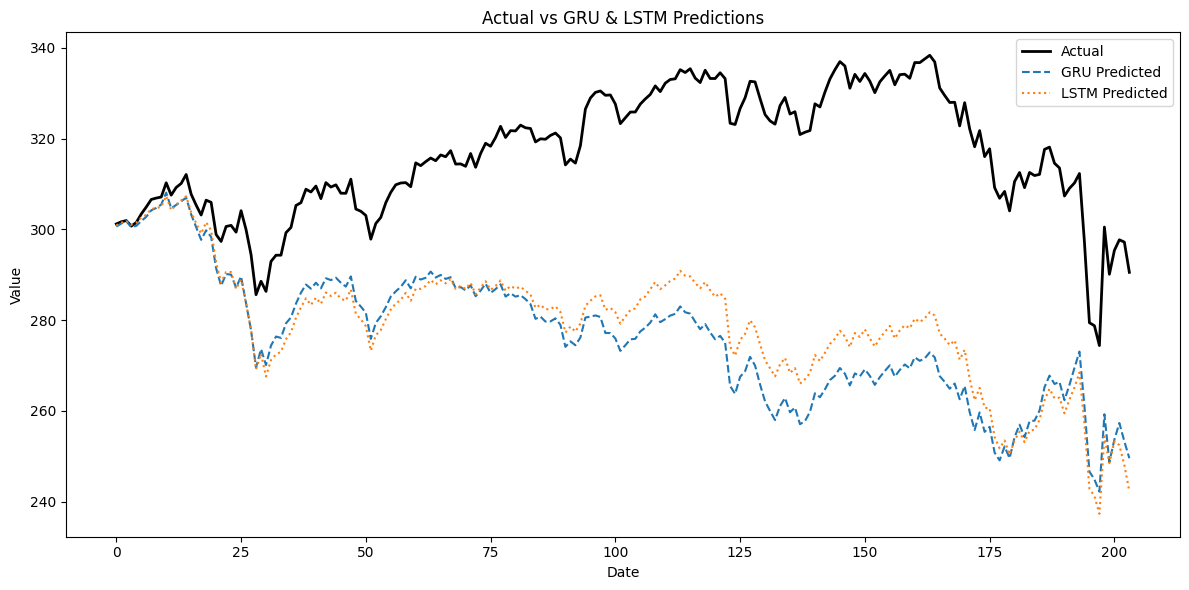

In [261]:
check_Df = convert_return_to_price(y_true, gru_pred, initial_price=300)
check_Df_lstm = convert_return_to_price(y_true, lstm_pred, initial_price=300)
plt.figure(figsize=(12,6))

# plot Actual once (solid black)
plt.plot(check_Df.index, check_Df['Actual'],
         label='Actual', color='black', linewidth=2)

# plot GRU predictions (dashed)
plt.plot(check_Df.index, check_Df['Predicted'],
         label='GRU Predicted', linestyle='--', linewidth=1.5)

# plot LSTM predictions (dotted)
plt.plot(check_Df_lstm.index, check_Df_lstm['Predicted'],
         label='LSTM Predicted', linestyle=':', linewidth=1.5)

# labels, title, legend
plt.title('Actual vs GRU & LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()

plt.show()
#plt.figure(figsize=(14, 6))
#line_plot(check_Df.index, check_Df['Actual'], check_Df['Predicted'])
#plt.figure(figsize=(14, 6))
#line_plot(check_Df_lstm.index, check_Df_lstm['Actual'], check_Df_lstm['Predicted'])
#plt.show()

In [280]:
df_return1 = pd.merge(
    check_Df_lstm,
    check_Df,
    on='Actual',
    how='left',
    suffixes=('_LSTM', '_GRU')
)
df_return1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Actual          204 non-null    float64
 1   Predicted_LSTM  204 non-null    float32
 2   Predicted_GRU   204 non-null    float32
dtypes: float32(2), float64(1)
memory usage: 3.3 KB


In [282]:
df_return1.to_csv(rf'{directory}/return1_deep_models.csv')

### LSTM

In [244]:
model_lstm = train_lstm(
    X_train, y_train,X_test,y_test,y_scale,
    learning_rate=0.005,
    epochs=30,
    num_layers=3,
    units=(32, 32, 92),
    window_size=1,
    batch_size=None,
    patience=5,
    checkpoint_path='best_return_lstm.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=0.1
)[0]

Epoch 1/30
47/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8181
Epoch 1: val_loss improved from inf to 0.63381, saving model to raw_files/best_return_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8491 - val_loss: 0.6338
Epoch 2/30
44/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4278
Epoch 2: val_loss did not improve from 0.63381
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4635 - val_loss: 0.6743
Epoch 3/30
45/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3075
Epoch 3: val_loss improved from 0.63381 to 0.56747, saving model to raw_files/best_return_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3373 - val_loss: 0.5675
Epoch 4/30
45/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2991
Epoch 4: val_loss improved from 0.56747 to 0.53649, saving model to raw_files/best_return_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3231 - val_loss: 0.5365
Epoch 5/30
45/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2251
Epoch 5: val_loss did not improve from 0.53649
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2450 - val_loss: 0.6002
Epoch 6/30
44/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2149
Epoch 6: val_loss improved from 0.53649 to 0.48685, saving model to raw_files/best_return_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2332 - val_loss: 0.4868
Epoch 7/30
44/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1730
Epoch 7: val_loss improved from 0.48685 to 0.47125, saving model to raw_files/best_return_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1857 - val_loss: 0.4712
Epoch 8/30
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1769
Epoch 8: val_loss did not improve from 0.47125
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1793 - val_loss: 0.6130
Epoch 9/30
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2194
Epoch 9: val_loss did not improve from 0.47125
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2224 - val_loss: 0.5999
Epoch 10/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2164
Epoch 10: val_loss improved from 0.47125 to 0.34176, saving model to raw_files/best_return_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2169 - val_loss: 0.3418
Epoch 11/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1723
Epoch 11: val_loss improved from 0.34176 to 0.32779, saving model to raw_files/best_return_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1728 - val_loss: 0.3278
Epoch 12/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1377
Epoch 12: val_loss did not improve from 0.32779
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1383 - val_loss: 0.4200
Epoch 13/30
54/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1210
Epoch 13: val_loss did not improve from 0.32779
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1227 - val_loss: 0.3912
Epoch 14/30
45/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1058
Epoch 14: val_loss did not improve from 0.32779
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1149 - val_loss: 0.3716
Epoch 15/30
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1151
Epoch 15: val_loss improved from 0.32779 to 0.30856, saving model to raw_files/best_return_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1163 - val_loss: 0.3086
Epoch 16/30
51/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0953
Epoch 16: val_loss did not improve from 0.30856
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0986 - val_loss: 0.3420
Epoch 17/30
44/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1006
Epoch 17: val_loss did not improve from 0.30856
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1074 - val_loss: 0.3566
Epoch 18/30
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1286
Epoch 18: val_loss did not improve from 0.30856
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1297 - val_loss: 0.4880
Epoch 19/30
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1543
Epoch 19: val_loss did not improve from 0.30856
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1550 - val_loss: 0.4021
Epoch 20/30
44/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1119
Epoch 20: val_loss did not improve from 0.30856
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1203 - val_loss:

### GRU

In [ ]:
model_gru = train_gru(
    X_train, y_train,X_test,y_test,y_scale,
    learning_rate=0.0025,
    epochs=30,
    num_layers=2,
    units=(128,92),
    window_size=1,
    batch_size=32,
    patience=5,
    checkpoint_path='best_return_gru.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None
)[0] 

Epoch 1/30
49/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8251
Epoch 1: val_loss improved from inf to 0.44609, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8081 - val_loss: 0.4461
Epoch 2/30
48/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2917
Epoch 2: val_loss improved from 0.44609 to 0.34989, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2930 - val_loss: 0.3499
Epoch 3/30
48/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1972
Epoch 3: val_loss did not improve from 0.34989
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1979 - val_loss: 0.3704
Epoch 4/30
47/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1723
Epoch 4: val_loss improved from 0.34989 to 0.28162, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1718 - val_loss: 0.2816
Epoch 5/30
47/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1569
Epoch 5: val_loss improved from 0.28162 to 0.24388, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1575 - val_loss: 0.2439
Epoch 6/30
48/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1559
Epoch 6: val_loss did not improve from 0.24388
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1561 - val_loss: 0.2529
Epoch 7/30
48/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1506
Epoch 7: val_loss improved from 0.24388 to 0.23949, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1491 - val_loss: 0.2395
Epoch 8/30
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1304
Epoch 8: val_loss did not improve from 0.23949
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1305 - val_loss: 0.3238
Epoch 9/30
48/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1599
Epoch 9: val_loss did not improve from 0.23949
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1563 - val_loss: 0.2567
Epoch 10/30
47/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1333
Epoch 10: val_loss did not improve from 0.23949
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1313 - val_loss: 0.2788
Epoch 11/30
49/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1167
Epoch 11: val_loss improved from 0.23949 to 0.23684, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1162 - val_loss: 0.2368
Epoch 12/30
54/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1092
Epoch 12: val_loss did not improve from 0.23684
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1089 - val_loss: 0.2578
Epoch 13/30
48/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1048
Epoch 13: val_loss did not improve from 0.23684
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1039 - val_loss: 0.2396
Epoch 14/30
46/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0953
Epoch 14: val_loss did not improve from 0.23684
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0948 - val_loss: 0.2477
Epoch 15/30
50/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0932
Epoch 15: val_loss did not improve from 0.23684
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0927 - val_loss: 0.2433
Epoch 16/30
50/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0874
Epoch 16: val_loss did not improve from 0.23684
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0872 - val_loss:

### Creating a sequence as features & split the data 

In [245]:
results = evaluate_models(model_gru, model_lstm, X_test, y_test, scaler_y)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GRU  - MSE: 0.1830, R²: 0.8905
LSTM - MSE: 0.3239, R²: 0.8062


# Now I will add more features 

In [262]:
print(cols)

['SPY_return', 'QQQ_Close', '^RUT', 'abs_vix', 'MSFT', 'stdev_5', '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d', 'abs_yield_curve', 'std_price', 'SPY_AbsChange', 'abs_vol', '2Y_Yield', 'EUR', 'SPY_RSI', 'DXY', 'JPY', 'month', 'day_of_week', '^TNX', '^VIX', '^N225', 'BTC-USD', 'EMA_200', 'USO', '^VIX_rank', 'GLD', 'SLV', 'CPER', 'EMA_20', 'MACD', 'streak']


**Add more features**

In [264]:
# Now with extended features :
X_train_ext, X_test_ext, y_train_ext, y_test_ext, scaler_X_ext, scaler_y_ext = prepare_sequence_data(
    return_data1, cols, 5, 'SPY_return', test_size=0.1
)

## Search for the best hyperparameters
**Model with the extended features**

In [360]:
best_return_gru2, best_loss_return_gru2, best_cfg_return_gru2 = search_best_model(
    model_type="GRU",                # or "LSTM"
    X_train=X_train_ext, y_train=y_train_ext,
    X_val=X_test_ext,  y_val=y_test_ext,
    window_size=1, # None since we reshape to (samples, 1, features)
    path='_best_return_gru2.keras',
    layer_options=[1,2,3],
    unit_options=[64,128,16],
    epochs=30,
    batch_size=32,
    patience=5,
    learning_rates=(0.002),
    dense_units = None,
    dense_activation='relu',
    dropout_rate=None
)
print("Best loss:", best_loss_return_gru2, "Config:", best_cfg_return_gru2)


Best loss: 0.09048323333263397 Config: {'model_type': 'GRU', 'n_layers': 2, 'units': (64, 16), 'learning_rate': 0.002, 'dense_units': None, 'dense_activation': 'relu', 'dropout_rate': None}


In [63]:
best_return_lstm2, best_loss_return_lstm2, best_return_lstm2_cfg = search_best_model(
    model_type="LSTM",                # or "LSTM"
    X_train=X_train_ext, y_train=y_train_ext,
    X_val=X_test_ext,  y_val=y_test_ext,
    window_size=1,
    path='_best_return_lstm2.keras',
    layer_options=[1,2,3],
    unit_options=[128,64,32],
    epochs=30,
    batch_size=32,
    patience=5,
    learning_rates=(0.002,),
    dense_units=4,
    dense_activation='relu',
    dropout_rate=None # None for no dropout
)
print("Best loss:", best_loss_return_lstm2, "Config:", best_return_lstm2_cfg)

Best loss: 0.08791977912187576 Config: {'model_type': 'LSTM', 'n_layers': 2, 'units': (128, 128), 'learning_rate': 0.002, 'dense_units': 4, 'dense_activation': 'relu', 'dropout_rate': None}


### Display the resaults 

In [65]:
results2,pred_gru2,pred_lstm2,y_true = evaluate_models(best_return_gru2, best_return_lstm2, X_test_ext, y_test_ext, scaler_y)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
GRU  - MSE: 0.0837, R²: 0.9499
LSTM - MSE: 0.0923, R²: 0.9448


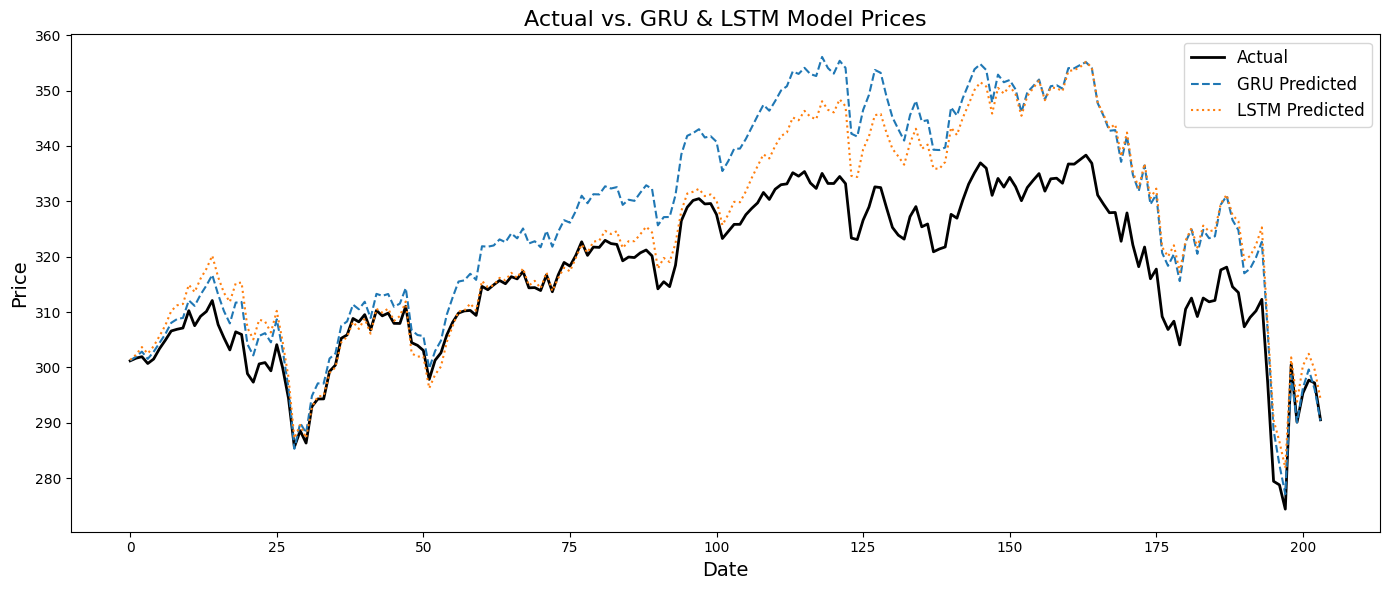

In [70]:
#convering to prices and plotting the results
check_Df = convert_return_to_price(y_true, pred_gru2, initial_price=300)
check_Df_lstm = convert_return_to_price(y_true, pred_lstm2, initial_price=300)
plt.figure(figsize=(14, 6))

# plot actual once
plt.plot(check_Df.index, check_Df['Actual'], color='black', linewidth=2, label='Actual')

# plot GRU predictions
plt.plot(check_Df.index, check_Df['Predicted'],
         linestyle='--', linewidth=1.5, label='GRU Predicted')

# plot LSTM predictions
plt.plot(check_Df_lstm.index, check_Df_lstm['Predicted'],
         linestyle=':', linewidth=1.5, label='LSTM Predicted')

# labels and title
plt.title('Actual vs. GRU & LSTM Model Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

# legend and layout
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()


### **Add all of the features and use L1 penalty to pick the best ones**


In [45]:
# A function to shift data by a specified number of periods for multiple columns
def shift_data(df,columns,shift):
    for col in columns:
        for shi in range(1, shift + 1):
            df[f"{col}_shift_{shi}"] = df[col].shift(shi)
    df = df.dropna()
    return df

In [ ]:
# I Found this columns to be importante 
shifted_columns = ['GLD', 'SLV', 'DX-Y.NYB', 'CPER']
return_data2 = return_data1.copy()
return_data2 = shift_data(return_data2, shifted_columns, 5)
cols = cols + [f"{col}_shift_{shi}" for col in shifted_columns for shi in range(1, 6)]

cols = cols + shifted_columns
#cols.remove('ds')

ValueError: list.remove(x): x not in list

In [48]:
all_feat = return_data1.columns.to_list()
print(all_feat)
all_feat.remove('ds')

['SPY_return', 'QQQ_Close', '^RUT', '^VIX', 'EMA_20', 'avgreturn5d', '^GDAXI', 'stdev_5', 'qqq_mean', 'GOOG', 'MSFT', '^FTSE', 'AAPL', 'std_price', 'abs_yield_curve', 'high-low', 'UNG', 'stdev', 'abs_vix', 'SLV', '^TNX', 'EMA_200', 'BTC-USD', 'EMA_50', 'USO', 'CPER', 'JPY=X', 'CNYUSD=X', 'before_high-low', 'SPY_RSI', 'GLD', 'IWM_avg5d', 'shiler pe', 'SPY_Volume', 'abs_vol', '^N225', 'SPY_AbsChange', 'avgreturn10d', 'IEI', 'Yestrady', 'abs_2Y_Yield', 'DX-Y.NYB', 'JPY', 'EUR=X', 'yield_curve', 'IWM_std_5d', 'days_since_fomc', 'qqq_std', '2Y_Yield', 'EUR', 'QQQ_Volume', 'DXY', 'day', 'Monday', 'Actual_GDP', 'vol_above_mean', 'Actual_FOMC', 'SPY_Streak', 'Actual_CPI', 'Tuesday', '^VIX_rank', 'market_closed_count', 'Wednesday', 'May', 'GDP_vs_forecast', 'February', 'ds', 'RSI_14', 'MACD', 'streak', 'month', 'day_of_week']


In [56]:
# Now with extended features :
X_train_ext, X_test_ext, y_train_ext, y_test_ext, scaler_X_ext, scaler_y_ext = prepare_sequence_data(
    return_data2, all_feat, 5, 'SPY_return', test_size=0.1
)

**Searcing using L1 penalty on the data with all the features :**

In [57]:
best_return_gru3, best_loss_return_gru3, best_cfg_return_gru3, feat_gru = search_best_model_with_reg(
    model_type="GRU",                # or "LSTM"
    X_train=X_train_ext, y_train=y_train_ext,
    X_val=X_test_ext,  y_val=y_test_ext,
    window_size=1, # None since we reshape to (samples, 1, features)
    path='_best_return_gru3.keras',
    layer_options=[1,2,3],
    unit_options=[32,128,64],
    epochs=30,
    batch_size=32,
    patience=3,
    learning_rates=(0.0025,0.002),
    dense_units = 4,
    dense_activation='relu',
    dropout_rate=None,
    l1_penalty=0.01,  # L1 regularization strength
    use_l1=True,  # Use L1 regularization
)
print("Best loss:", best_loss_return_gru3, "Config:", best_cfg_return_gru3)


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.7511162757873535 Config: {'model_type': 'GRU', 'n_layers': 1, 'units': (64,), 'learning_rate': 0.002, 'dense_units': 4, 'dense_activation': 'relu', 'dropout_rate': None, 'use_l1': True, 'l1_penalty': 0.01}


In [ ]:
best_return_lstm2, best_loss_return_lstm2, best_return_lstm2_cfg , feat_lstm = search_best_model_with_reg(
    model_type="LSTM",                # or "LSTM"
    X_train=X_train_ext, y_train=y_train_ext,
    X_val=X_test_ext,  y_val=y_test_ext,
    window_size=1,
    layer_options=[1,2,3],
    unit_options=[32,128,92],
    epochs=30,
    batch_size=32,
    patience=3,
    learning_rates=(0.0025,0.002),
    dense_units = 4,
    dense_activation='relu',
    dropout_rate=None,
    l1_reg=0.01,  # L1 regularization strength
    use_l1=True,  # Use L1 regularization
)

print("Best loss:", best_loss_return_lstm2, "Config:", best_return_lstm2_cfg ,'/n', 'best_model_gru:',feat_gru)

In [354]:
model_gru = train_gru(
    X_train_ext, y_train_ext,X_test_ext, y_test_ext,
    y_scale,
    learning_rate=0.002,
    epochs=40,
    num_layers=3,
    units=(64,128,16),
    window_size=1,
    batch_size=32,
    patience=5,
    checkpoint_path='best_return_gru.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate=None
)[0] 

Epoch 1/40
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5625
Epoch 1: val_loss improved from inf to 0.27511, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.5585 - val_loss: 0.2751
Epoch 2/40
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1164
Epoch 2: val_loss improved from 0.27511 to 0.20054, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1187 - val_loss: 0.2005
Epoch 3/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0860
Epoch 3: val_loss improved from 0.20054 to 0.13255, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0864 - val_loss: 0.1326
Epoch 4/40
54/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0590
Epoch 4: val_loss improved from 0.13255 to 0.11336, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0608 - val_loss: 0.1134
Epoch 5/40
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0456
Epoch 5: val_loss improved from 0.11336 to 0.09514, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0465 - val_loss: 0.0951
Epoch 6/40
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0400
Epoch 6: val_loss improved from 0.09514 to 0.08054, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0405 - val_loss: 0.0805
Epoch 7/40
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0371
Epoch 7: val_loss did not improve from 0.08054
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0375 - val_loss: 0.0926
Epoch 8/40
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0392
Epoch 8: val_loss did not improve from 0.08054
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0397 - val_loss: 0.0931
Epoch 9/40
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0531
Epoch 9: val_loss improved from 0.08054 to 0.07925, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0534 - val_loss: 0.0792
Epoch 10/40
53/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0459
Epoch 10: val_loss improved from 0.07925 to 0.06226, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0467 - val_loss: 0.0623
Epoch 11/40
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0332
Epoch 11: val_loss did not improve from 0.06226
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0337 - val_loss: 0.0733
Epoch 12/40
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0302
Epoch 12: val_loss did not improve from 0.06226
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0304 - val_loss: 0.0712
Epoch 13/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0266
Epoch 13: val_loss did not improve from 0.06226
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0267 - val_loss: 0.0717
Epoch 14/40
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0239
Epoch 14: val_loss improved from 0.06226 to 0.05958, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0241 - val_loss: 0.0596
Epoch 15/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0254
Epoch 15: val_loss did not improve from 0.05958
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0254 - val_loss: 0.0798
Epoch 16/40
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0246
Epoch 16: val_loss did not improve from 0.05958
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0249 - val_loss: 0.0677
Epoch 17/40
53/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0230
Epoch 17: val_loss did not improve from 0.05958
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0233 - val_loss: 0.0882
Epoch 18/40
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0223
Epoch 18: val_loss improved from 0.05958 to 0.05639, saving model to raw_files/best_return_gru.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0223 - val_loss: 0.0564
Epoch 19/40
53/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151
Epoch 19: val_loss did not improve from 0.05639
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0153 - val_loss: 0.0910
Epoch 20/40
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150
Epoch 20: val_loss did not improve from 0.05639
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0150 - val_loss: 0.0731
Epoch 21/40
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0120
Epoch 21: val_loss did not improve from 0.05639
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0123 - val_loss: 0.0664
Epoch 22/40
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153
Epoch 22: val_loss did not improve from 0.05639
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0154 - val_loss: 0.0663
Epoch 23/40
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0155
Epoch 23: val_loss did not improve from 0.05639
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0156 

In [331]:
model_lstm = train_lstm(
    X_train_ext, y_train_ext,X_test_ext, y_test_ext,
    y_scale,
    learning_rate=0.002,
    epochs=30,
    num_layers=2,
    units=(96,128),
    window_size=1,
    batch_size=32,
    patience=5,
    checkpoint_path='_best_lstm.h5',
    dense_units=None,
    dense_activation='relu',
    dropout_rate = None,
)[0]

Epoch 1/30
54/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4466
Epoch 1: val_loss improved from inf to 0.26193, saving model to raw_files/_best_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4436 - val_loss: 0.2619
Epoch 2/30
50/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1927
Epoch 2: val_loss did not improve from 0.26193
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2073 - val_loss: 0.6462
Epoch 3/30
54/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2399
Epoch 3: val_loss did not improve from 0.26193
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2423 - val_loss: 0.5187
Epoch 4/30
53/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1663
Epoch 4: val_loss did not improve from 0.26193
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1689 - val_loss: 0.3529
Epoch 5/30
52/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0980
Epoch 5: val_loss did not improve from 0.26193
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1013 - val_loss: 0.3127
Epoch 6/30
51/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0684
Epoch 6: val_loss improved from 0.26193 to 0.20040, saving model to raw_files/_best_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0706 - val_loss: 0.2004
Epoch 7/30
51/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0490
Epoch 7: val_loss improved from 0.20040 to 0.10315, saving model to raw_files/_best_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0505 - val_loss: 0.1032
Epoch 8/30
53/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0480
Epoch 8: val_loss improved from 0.10315 to 0.08464, saving model to raw_files/_best_lstm.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0486 - val_loss: 0.0846
Epoch 9/30
49/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0456
Epoch 9: val_loss did not improve from 0.08464
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0479 - val_loss: 0.1100
Epoch 10/30
52/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0469
Epoch 10: val_loss did not improve from 0.08464
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0472 - val_loss: 0.0999
Epoch 11/30
53/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0429
Epoch 11: val_loss did not improve from 0.08464
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0438 - val_loss: 0.1144
Epoch 12/30
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0430
Epoch 12: val_loss did not improve from 0.08464
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0431 - val_loss: 0.1057
Epoch 13/30
49/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333
Epoch 13: val_loss did not improve from 0.08464
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0344 - val_loss: 0

In [356]:
metrics,pred_gru_r_ext,pred_lstm_r_ext,y_true_ext =evaluate_models(model_gru,model_lstm, X_test_ext, y_test_ext, scaler_y)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
GRU  - MSE: 0.0592, R²: 0.9646
LSTM - MSE: 0.0888, R²: 0.9468


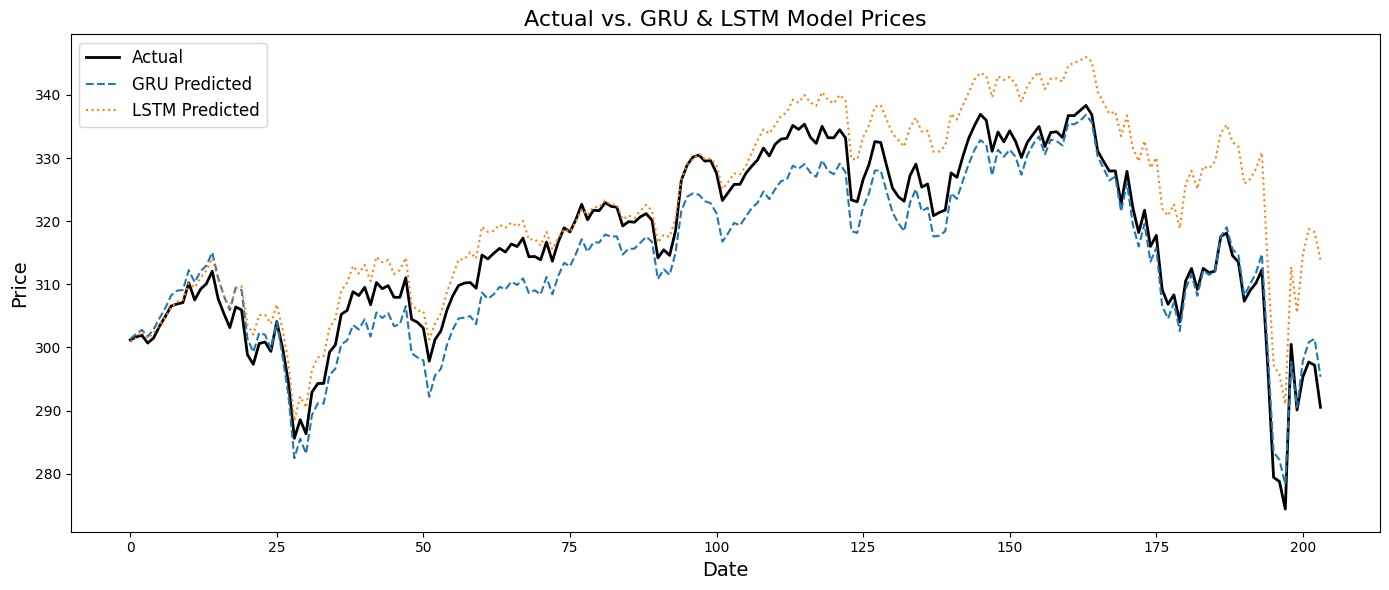

In [357]:
#convering to prices and plotting the results
check_Df_ext = convert_return_to_price(y_true_ext, pred_gru_r_ext, initial_price=300)
check_Df_lstm_ext = convert_return_to_price(y_true_ext, pred_lstm_r_ext, initial_price=300)
plt.figure(figsize=(14, 6))

# plot actual once
plt.plot(check_Df_ext.index, check_Df_ext['Actual'], color='black', linewidth=2, label='Actual')

# plot GRU predictions
plt.plot(check_Df_ext.index, check_Df_ext['Predicted'],
         linestyle='--', linewidth=1.5, label='GRU Predicted')

# plot LSTM predictions
plt.plot(check_Df_lstm_ext.index, check_Df_lstm_ext['Predicted'],
         linestyle=':', linewidth=1.5, label='LSTM Predicted')

# labels and title
plt.title('Actual vs. GRU & LSTM Model Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

# legend and layout
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()


In [358]:
df_return2 = pd.merge(
    check_Df_lstm_ext,
    check_Df_ext,
    on='Actual',
    how='left',
    suffixes=('_LSTM', '_GRU')
)

df_return2.to_csv(rf'{directory}/reuturn_deep_ext.csv')


# Return model with economic data 

In [313]:
external_data.head()

NameError: name 'external_data' is not defined